This notebook performs quality control.

# Midterm

Paper: PMID 27667667
Data link (available in paper): https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-5061

From E-MTAB-5061.idf.txt:
Format of the datafile ‘pancreas_refseq_rpkms_counts_3514sc.txt’: The file contains both the normalized rpkm values and the raw read counts for each sample. Columns correspond to samples and rows to genes. The first line of the file (starting with: #samples) contains the sample IDs to be used as column labels for both the rpkm and counts. The columns of the rpkm and the counts have the same order with the sample IDs. Columns 1:3514 correspond to rpkm values, Columns 3515:7028 correspond to read counts. Rows 1:26179 correspond to data for RefSeq genes, Rows 26180:26271 correspond to data for the 92 external RNA spike-in controls (ERCCs), Row 26272 (last) contains data for ‘eGFP’.

In [1]:
library(dplyr)
library(Seurat)
library(patchwork)
options(repr.plot.width=16, repr.plot.height=8)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




## Segerstolpe dataset

### Getting data

In [2]:
cell.barcodes <- scan(text = readLines("../data/E-MTAB-5061/pancreas_refseq_rpkms_counts_3514sc.txt", 1), 
                      what = "", quiet = TRUE)[-1] # 3514 cell barcodes
head(cell.barcodes)

[1] "HP1502401_N13" "HP1502401_D14" "HP1502401_F14" "HP1502401_J13"
[5] "HP1502401_B13" "HP1502401_H13"

In [3]:
count = read.table('../data/E-MTAB-5061/pancreas_refseq_rpkms_counts_3514sc.txt',sep='\t')
head(count)

V1      V2                                  V3 V4 V5 V6 V7 V8        V9
1 SGIP1   NM_032291                           0  0  0  0  0    0.00000 0 
2 AZIN2   NM_052998+NM_001293562              0  0  0  0  0   41.51929 0 
3 CLIC4   NM_013943                           0  0  0  0  0    0.00000 0 
4 AGBL4   NM_032785                           0  0  0  0  0    0.00000 0 
5 NECAP2  NM_001145277+NM_001145278+NM_018090 0  0  0  0  0   13.99272 0 
6 SLC45A1 NM_001080397                        0  0  0  0  0  149.80023 0 
  V10      ⋯ V7021 V7022 V7023 V7024 V7025 V7026 V7027 V7028 V7029 V7030
1  0.00000 ⋯ 0      0     0     7    0     4      0    0     0     0    
2  0.00000 ⋯ 0      0     0    16    0     0      0    0     0     4    
3  0.00000 ⋯ 2     20    64    18    0     0      0    0     0     1    
4  0.00000 ⋯ 0      0     0     0    0     0      5    0     0     0    
5 18.92435 ⋯ 0      0     0    14    0     1     47    7     0     6    
6 78.07885 ⋯ 0      0     0     0    0     0      1    0     0     1

In [4]:
gene.meta=count[,1:2] # First two columns are gene symbols and IDs
head(gene.meta)

V1      V2                                 
1 SGIP1   NM_032291                          
2 AZIN2   NM_052998+NM_001293562             
3 CLIC4   NM_013943                          
4 AGBL4   NM_032785                          
5 NECAP2  NM_001145277+NM_001145278+NM_018090
6 SLC45A1 NM_001080397

Remove metadata from the `count`.

In [5]:
count=count[,-(1:2)]
head(count)

V3 V4 V5 V6 V7 V8        V9 V10      V11       V12       ⋯ V7021 V7022 V7023
1 0  0  0  0  0    0.00000 0   0.00000  0.000000 0.0000000 ⋯ 0      0     0   
2 0  0  0  0  0   41.51929 0   0.00000  0.000000 0.0000000 ⋯ 0      0     0   
3 0  0  0  0  0    0.00000 0   0.00000  5.463685 0.2308227 ⋯ 2     20    64   
4 0  0  0  0  0    0.00000 0   0.00000  0.000000 0.0000000 ⋯ 0      0     0   
5 0  0  0  0  0   13.99272 0  18.92435 44.923718 0.0000000 ⋯ 0      0     0   
6 0  0  0  0  0  149.80023 0  78.07885  0.000000 0.0000000 ⋯ 0      0     0   
  V7024 V7025 V7026 V7027 V7028 V7029 V7030
1  7    0     4      0    0     0     0    
2 16    0     0      0    0     0     4    
3 18    0     0      0    0     0     1    
4  0    0     0      5    0     0     0    
5 14    0     1     47    7     0     6    
6  0    0     0      1    0     0     1

We only care about read counts, not rpkm values.

In [6]:
count=as.matrix(count[,3515:7028]) # Columns 3515:7028 correspond to read counts.
head(count, 3)

V3517 V3518 V3519 V3520 V3521 V3522 V3523 V3524 V3525 V3526 ⋯ V7021 V7022
[1,] 0     0     0     0     0     0     0     0      0    0     ⋯ 0      0   
[2,] 0     0     0     0     0     3     0     0      0    0     ⋯ 0      0   
[3,] 0     0     0     0     0     0     0     0     14    1     ⋯ 2     20   
     V7023 V7024 V7025 V7026 V7027 V7028 V7029 V7030
[1,]  0     7    0     4     0     0     0     0    
[2,]  0    16    0     0     0     0     0     4    
[3,] 64    18    0     0     0     0     0     1

### Labeling rows and columns 

We add column names and row names with genes and samples.

In [7]:
rownames(count)=gene.meta[,1]
colnames(count)=cell.barcodes
head(count)

HP1502401_N13 HP1502401_D14 HP1502401_F14 HP1502401_J13 HP1502401_B13
SGIP1   0             0             0             0             0            
AZIN2   0             0             0             0             0            
CLIC4   0             0             0             0             0            
AGBL4   0             0             0             0             0            
NECAP2  0             0             0             0             0            
SLC45A1 0             0             0             0             0            
        HP1502401_H13 HP1502401_J14 HP1502401_B14 HP1502401_A14 HP1502401_C14 ⋯
SGIP1    0            0              0             0            0             ⋯
AZIN2    3            0              0             0            0             ⋯
CLIC4    0            0              0            14            1             ⋯
AGBL4    0            0              0             0            0             ⋯
NECAP2   1            0             10            53            0             ⋯
SLC45A1 13            0             52             0            0             ⋯
        HP1525301T2D_O10 HP1526901T2D_H2 HP1526901T2D_I16 HP1526901T2D_F7
SGIP1   0                 0               0                7             
AZIN2   0                 0               0               16             
CLIC4   2                20              64               18             
AGBL4   0                 0               0                0             
NECAP2  0                 0               0               14             
SLC45A1 0                 0               0                0             
        HP1526901T2D_I23 HP1525301T2D_K3 HP1525301T2D_J10 HP1526901T2D_N8
SGIP1   0                4                0               0              
AZIN2   0                0                0               0              
CLIC4   0                0                0               0              
AGBL4   0                0                5               0              
NECAP2  0                1               47               7              
SLC45A1 0                0                1               0              
        HP1526901T2D_O11 HP1526901T2D_A8
SGIP1   0                0              
AZIN2   0                4              
CLIC4   0                1              
AGBL4   0                0              
NECAP2  0                6              
SLC45A1 0                1

In [8]:
rm(gene.meta, cell.barcodes)

In [9]:
dim(t(count))

[1]  3514 26271

### Ordering cells to match `cell.meta`

In [10]:
cell.meta = read.csv('../data/E-MTAB-5061/E-MTAB-5061.sdrf.txt',sep='\t')
head(cell.meta)

Source.Name Characteristics..organism. Characteristics..individual.
1 AZ_A1       Homo sapiens               H1                          
2 AZ_A3       Homo sapiens               H1                          
3 AZ_A4       Homo sapiens               H1                          
4 AZ_B6       Homo sapiens               H1                          
5 AZ_B7       Homo sapiens               H1                          
6 AZ_C12      Homo sapiens               H1                          
  Characteristics..sex. Characteristics..age. Unit..time.unit.
1 male                  43                    year            
2 male                  43                    year            
3 male                  43                    year            
4 male                  43                    year            
5 male                  43                    year            
6 male                  43                    year            
  Characteristics..body.mass.index. Characteristics..organism.status.
1 30.8                              post-mortem                      
2 30.8                              post-mortem                      
3 30.8                              post-mortem                      
4 30.8                              post-mortem                      
5 30.8                              post-mortem                      
6 30.8                              post-mortem                      
  Characteristics..clinical.information. Characteristics..organism.part. ⋯
1 HbA1c 5.0%                             pancreas                        ⋯
2 HbA1c 5.0%                             pancreas                        ⋯
3 HbA1c 5.0%                             pancreas                        ⋯
4 HbA1c 5.0%                             pancreas                        ⋯
5 HbA1c 5.0%                             pancreas                        ⋯
6 HbA1c 5.0%                             pancreas                        ⋯
  Comment.ENA_EXPERIMENT. Scan.Name       Comment.SUBMITTED_FILE_NAME.
1 ERX1700346              AZ_A1.fastq.gz  AZ_A1.fastq.gz              
2 ERX1700351              AZ_A3.fastq.gz  AZ_A3.fastq.gz              
3 ERX1700352              AZ_A4.fastq.gz  AZ_A4.fastq.gz              
4 ERX1700366              AZ_B6.fastq.gz  AZ_B6.fastq.gz              
5 ERX1700367              AZ_B7.fastq.gz  AZ_B7.fastq.gz              
6 ERX1700373              AZ_C12.fastq.gz AZ_C12.fastq.gz             
  Comment.ENA_RUN.
1 ERR1630013      
2 ERR1630018      
3 ERR1630019      
4 ERR1630033      
5 ERR1630034      
6 ERR1630040      
  Comment.FASTQ_URI.                                                          
1 ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/003/ERR1630013/ERR1630013.fastq.gz
2 ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/008/ERR1630018/ERR1630018.fastq.gz
3 ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/009/ERR1630019/ERR1630019.fastq.gz
4 ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/003/ERR1630033/ERR1630033.fastq.gz
5 ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/004/ERR1630034/ERR1630034.fastq.gz
6 ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/000/ERR1630040/ERR1630040.fastq.gz
  Protocol.REF.3 Derived.Array.Data.File                
1 P-MTAB-51966   pancreas_refseq_rpkms_counts_3514sc.txt
2 P-MTAB-51966   pancreas_refseq_rpkms_counts_3514sc.txt
3 P-MTAB-51966   pancreas_refseq_rpkms_counts_3514sc.txt
4 P-MTAB-51966   pancreas_refseq_rpkms_counts_3514sc.txt
5 P-MTAB-51966   pancreas_refseq_rpkms_counts_3514sc.txt
6 P-MTAB-51966   pancreas_refseq_rpkms_counts_3514sc.txt
  Comment..Derived.ArrayExpress.FTP.file.                                                                  
1 ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-5061/E-MTAB-5061.processed.1.zip
2 ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-5061/E-MTAB-5061.processed.1.zip
3 ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-5061/E-MTAB-5061.processed.1.zip
4 ftp://ftp.ebi.ac.uk/pub/databases/microa

In [11]:
table(cell.meta$Characteristics..individual.) # Six healthy individuals, four T2D patients


  H1   H2   H3   H4   H5   H6 T2D1 T2D2 T2D3 T2D4 
  96  352  383  383  383  383  383  383  384  384 

In [12]:
cell.meta=cell.meta[,1:5] # Remove unnecessary meta info for the cells
head(cell.meta)

Source.Name Characteristics..organism. Characteristics..individual.
1 AZ_A1       Homo sapiens               H1                          
2 AZ_A3       Homo sapiens               H1                          
3 AZ_A4       Homo sapiens               H1                          
4 AZ_B6       Homo sapiens               H1                          
5 AZ_B7       Homo sapiens               H1                          
6 AZ_C12      Homo sapiens               H1                          
  Characteristics..sex. Characteristics..age.
1 male                  43                   
2 male                  43                   
3 male                  43                   
4 male                  43                   
5 male                  43                   
6 male                  43

In [13]:
df = t(count)
df = df[cell.meta$Source.Name,]
head(df)

SGIP1 AZIN2 CLIC4 AGBL4 NECAP2 SLC45A1 TGFBR3 DBT RFWD2 C1orf21 ⋯
AZ_A1  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_A3  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_A4  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_B6  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_B7  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_C12 0     0     0     0     0      0       0      0   0     0       ⋯
       ERCC_1.83105469:mix1_3.66210938:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.91552734:mix1_1.83105469:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  1                                   
AZ_C12 0                                   
       ERCC_0.91552734:mix1_1.83105469:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.45776367:mix1_0.91552734:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.22888184:mix1_0.45776367:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.22888184:mix1_0.45776367:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.11444092:mix1_0.22888184:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.05722046:mix1_0.11444092:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.01430512:mix1_0.02861023:mix2 eGFP
AZ_A1  0                                    0   
AZ_A3  0                                    1   
AZ_A4  0                                    0   
AZ_B6  0                                    1   
AZ_B7  0                                    0   
AZ_C12 0                                    0

In [14]:
sum(cell.meta$Source.Name == rownames(df))

[1] 3514

In [15]:
dim(cell.meta)

[1] 3514    5

### Choosing only healthy individuals

Let's find some `Source.Name` that match healthy individuals:

In [16]:
head(cell.meta)

Source.Name Characteristics..organism. Characteristics..individual.
1 AZ_A1       Homo sapiens               H1                          
2 AZ_A3       Homo sapiens               H1                          
3 AZ_A4       Homo sapiens               H1                          
4 AZ_B6       Homo sapiens               H1                          
5 AZ_B7       Homo sapiens               H1                          
6 AZ_C12      Homo sapiens               H1                          
  Characteristics..sex. Characteristics..age.
1 male                  43                   
2 male                  43                   
3 male                  43                   
4 male                  43                   
5 male                  43                   
6 male                  43

In [17]:
healthy_cell.meta <- cell.meta %>%
    filter(Characteristics..individual. == c('H1') | 
           Characteristics..individual. == c('H2') | 
           Characteristics..individual. == c('H3') | 
           Characteristics..individual. == c('H4') | 
           Characteristics..individual. == c('H5') | 
           Characteristics..individual. == c('H6'))

In [18]:
head(healthy_cell.meta)

Source.Name Characteristics..organism. Characteristics..individual.
1 AZ_A1       Homo sapiens               H1                          
2 AZ_A3       Homo sapiens               H1                          
3 AZ_A4       Homo sapiens               H1                          
4 AZ_B6       Homo sapiens               H1                          
5 AZ_B7       Homo sapiens               H1                          
6 AZ_C12      Homo sapiens               H1                          
  Characteristics..sex. Characteristics..age.
1 male                  43                   
2 male                  43                   
3 male                  43                   
4 male                  43                   
5 male                  43                   
6 male                  43

Now we only choose cells from healthy individuals.

In [19]:
table(cell.meta$Characteristics..individual.)


  H1   H2   H3   H4   H5   H6 T2D1 T2D2 T2D3 T2D4 
  96  352  383  383  383  383  383  383  384  384 

In [20]:
96+352+383+383+383+383

[1] 1980

Looking at the table, we know there should be 1980 individuals.

In [21]:
df = df[healthy_cell.meta$Source.Name,]
dim(df)

[1]  1980 26271

### Quality control

Let's follow steps on [Seurat - Guided Clustering Tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html).

In [22]:
head(df)

SGIP1 AZIN2 CLIC4 AGBL4 NECAP2 SLC45A1 TGFBR3 DBT RFWD2 C1orf21 ⋯
AZ_A1  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_A3  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_A4  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_B6  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_B7  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_C12 0     0     0     0     0      0       0      0   0     0       ⋯
       ERCC_1.83105469:mix1_3.66210938:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.91552734:mix1_1.83105469:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  1                                   
AZ_C12 0                                   
       ERCC_0.91552734:mix1_1.83105469:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.45776367:mix1_0.91552734:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.22888184:mix1_0.45776367:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.22888184:mix1_0.45776367:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.11444092:mix1_0.22888184:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.05722046:mix1_0.11444092:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.01430512:mix1_0.02861023:mix2 eGFP
AZ_A1  0                                    0   
AZ_A3  0                                    1   
AZ_A4  0                                    0   
AZ_B6  0                                    1   
AZ_B7  0                                    0   
AZ_C12 0                                    0

Remove duplicated genes.

In [23]:
sum(duplicated(rownames(df)))

[1] 0

In [24]:
sum(duplicated(colnames(df)))

[1] 745

In [25]:
df = df[, !duplicated(colnames(df))]
sum(duplicated(colnames(df)))

[1] 0

In [26]:
dim(df)

[1]  1980 25526

We transpose our transpose to create a seurat object because Seurat object wants cells on columns and gens on rows.

In [27]:
so <- CreateSeuratObject(counts = t(df), project = "midterm", min.cells = 3, min.features = 200)
so

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”


An object of class Seurat 
20029 features across 1841 samples within 1 assay 
Active assay: RNA (20029 features, 0 variable features)
 1 layer present: counts

For Quality control, we want to look at the following:

- The number of unique genes detected in each cell.
  - Low-quality cells or empty droplets will often have very few genes.
  - Cell doublets or multiplets may exhibit an aberrantly high gene count.
- Similarly, the total number of molecules detected within a cell (correlates strongly with unique genes).
- The percentage of reads that map to the mitochondrial genome
  - Low-quality / dying cells often exhibit extensive mitochondrial contamination.
  - We calculate mitochondrial QC metrics with the `PercentageFeatureSet()` function, which calculates the percentage of counts originating from a set of features.
  - We use the set of all genes starting with MT- as a set of mitochondrial genes.

There is no mitochondrial genes in this data.

In [28]:
sum(PercentageFeatureSet(so, pattern = "^MT-"))

[1] 0

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


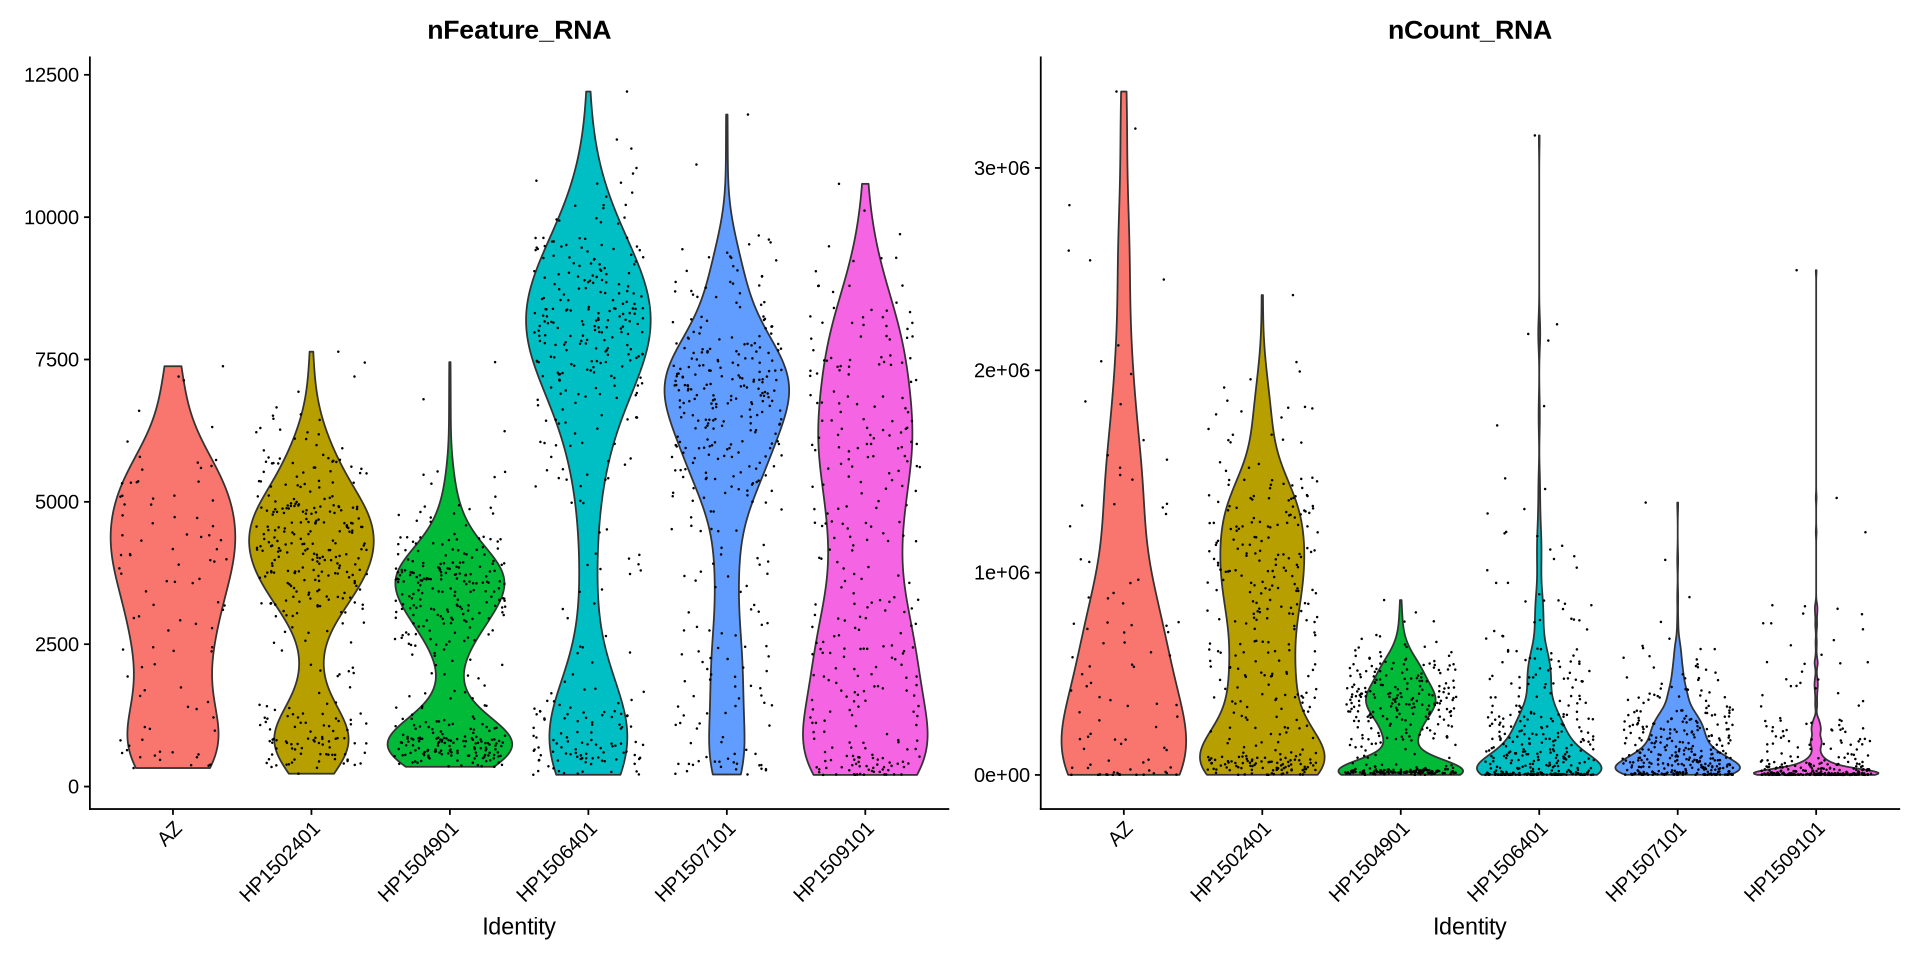

In [29]:
# Visualize QC metrics as a violin plot
VlnPlot(so, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

Not sure how to remove the warning message.

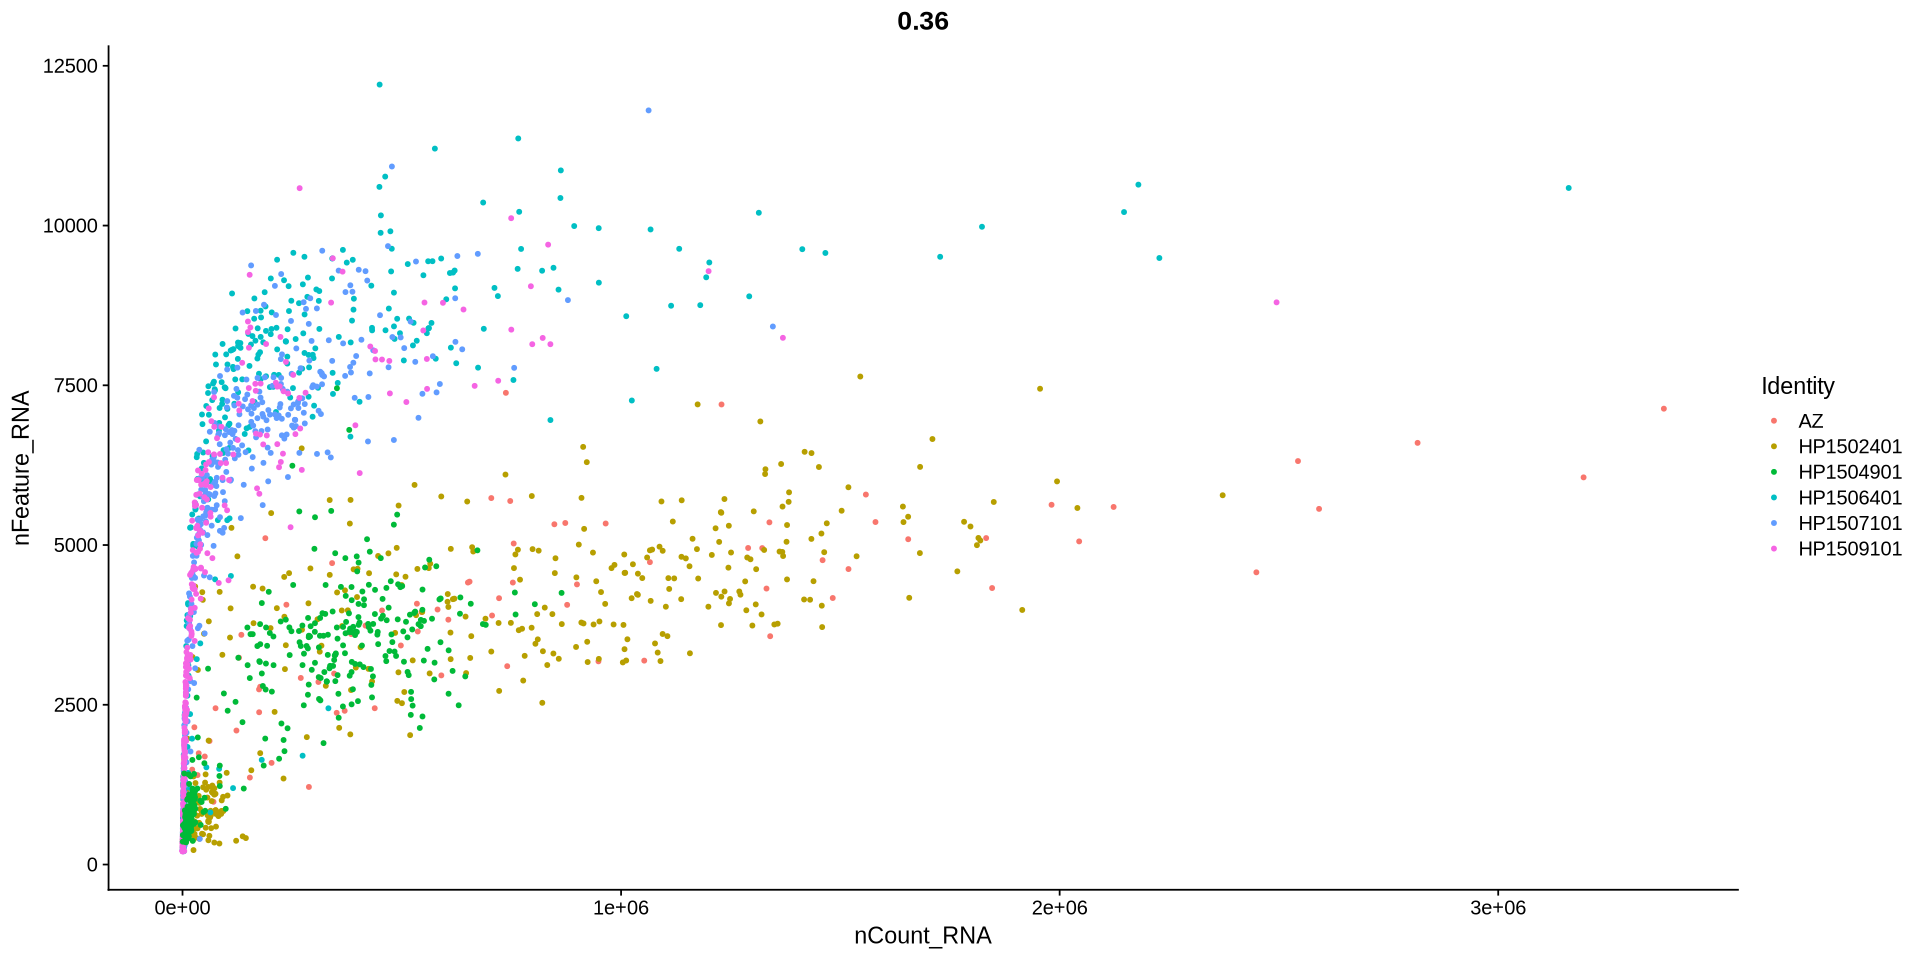

In [30]:
FeatureScatter(so, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

Removing may not be good yet because of the warning above.

In [31]:
so = subset(so, subset = nFeature_RNA > 200 & nFeature_RNA < 2500)

### Normalizing the data

In [32]:
so <- NormalizeData(so)
so

Normalizing layer: counts



An object of class Seurat 
20029 features across 590 samples within 1 assay 
Active assay: RNA (20029 features, 0 variable features)
 2 layers present: counts, data

### Highly variable features (feature selection)

We only care about genes that vary a lot. We chose top 2000 genes, but we could get away with smaller numbers.

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


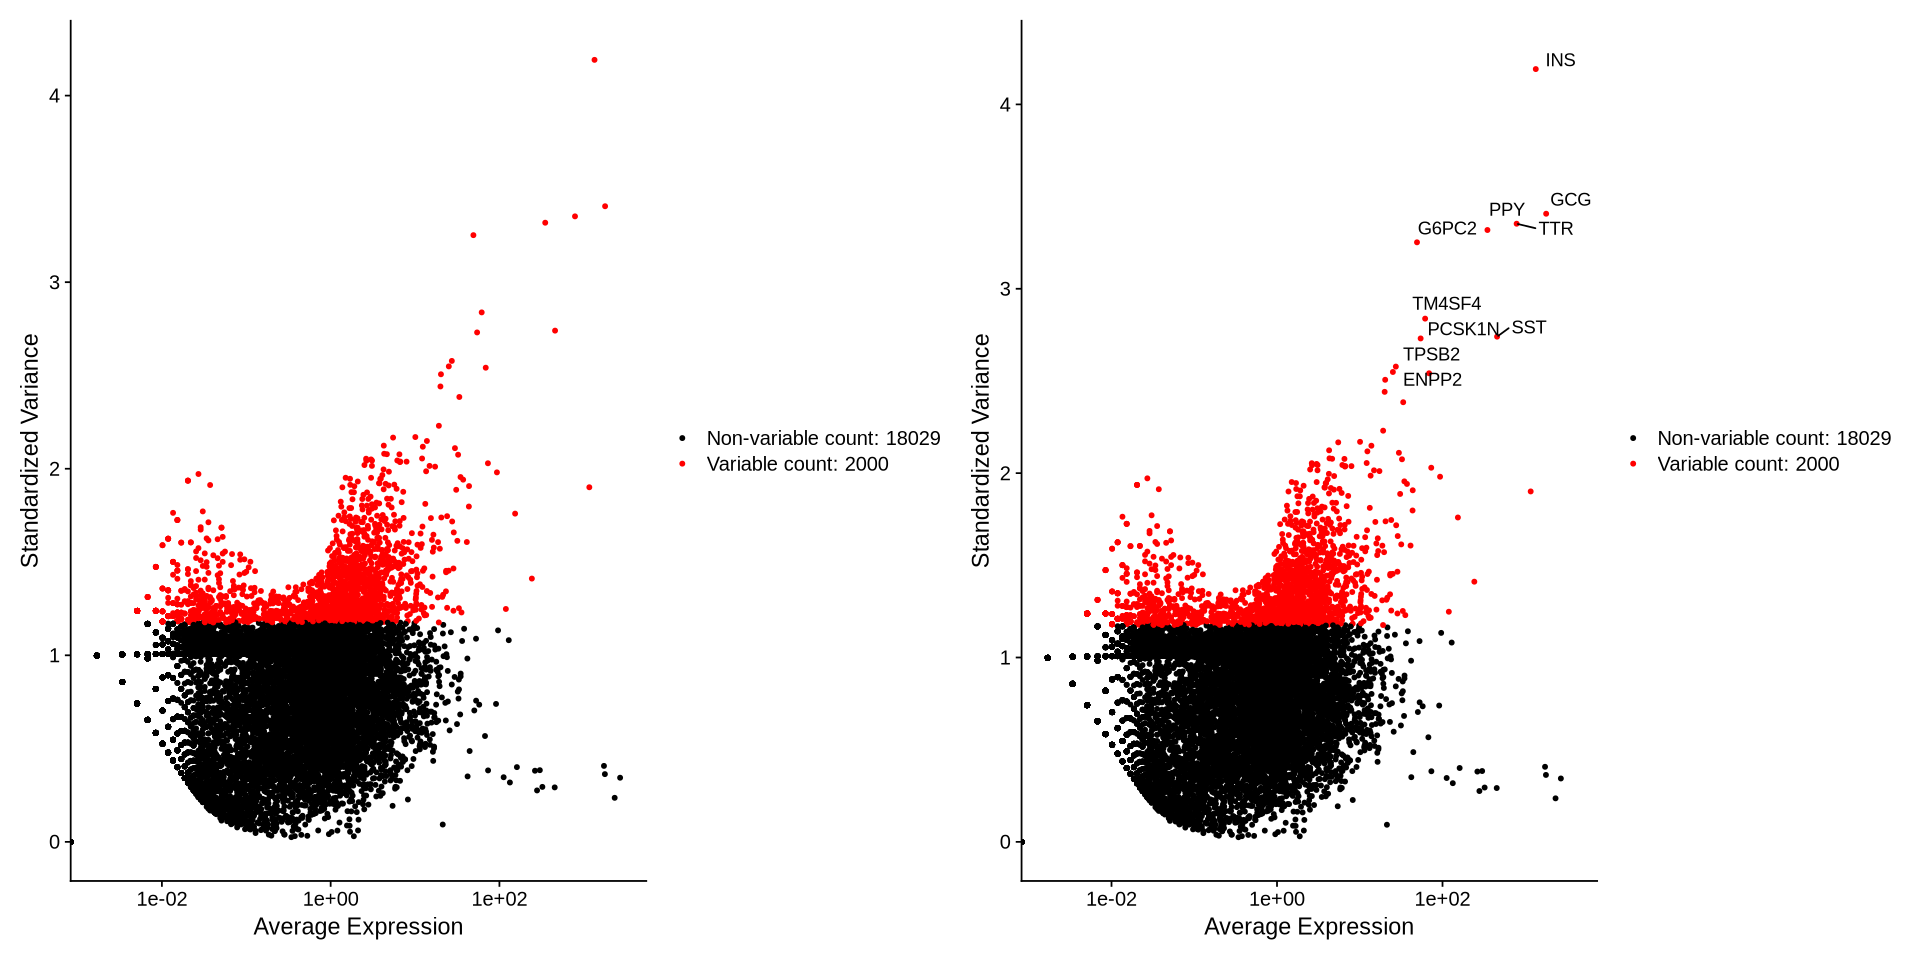

In [33]:
so <- FindVariableFeatures(so, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(so), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(so)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

### Scaling data

Before applying PCA, we have to scale our data so that mean is 0 and variance is 1 for each gene. By default, `ScaleData` only scales highly variable genes, but we want to scale all the genes. This helps us with visualization later.

In [34]:
all.genes <- rownames(so)
so <- ScaleData(so, features = all.genes)

Centering and scaling data matrix



### PCA

PCA allows us to reduce dimension so we can use clustering.

In [35]:
so <- RunPCA(so, features = VariableFeatures(object = so))
print(so[['pca']], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  B2M, MALAT1, CALM2, CALR, SEC22B, MDH1, TSPYL1, GHITM, PRKAR1A, RIN2 
	   RTN4, SRSF6, HSPA5, REEP3, PPP1CB, C6orf62, SCG3, MARCH6, HNRNPH1, SERINC1 
	   PRDX3, MAP1B, CD164, ATP6V1B2, ATRAID, PFKFB2, DPYSL2, ATP6AP2, ASAH1, PSMB5 
Negative:  PPY, ERCC-58.59375:mix1-58.59375:mix2, SST, ERCC-29.296875:mix1-58.59375:mix2, ERCC-7.32421875:mix1-7.32421875:mix2, ERCC-58.59375:mix1-117.1875:mix2, HBA1, CCDC170, SNORA55, ACTG2 
	   ERCC-14.6484375:mix1-3.66210938:mix2, DNAH6, LIN7A, DYTN, ZBTB32, PHF21B, SBF2-AS1, MYH13, HMGCS2, CACNA1C-IT3 
	   ALOX12B, SGOL1-AS1, CYB5RL, ZACN, PRSS1, SUSD5, EOMES, SPTA1, C8orf34, KIR3DX1 
PC_ 2 
Positive:  SCG5, RIN2, SCG3, PCP4, G6PC2, ENPP2, CHGB, TTR, MAP1B, SCG2 
	   TSPYL1, CACNB2, HEPACAM2, NKIRAS1, ACVR1C, MARCH6, SNAP25, FAM76A, LINC01099, GCG 
	   CFL2, REEP3, RAP1GDS1, MRPL42, CACUL1, PFN2, PRKAR1A, DPYSL2, ZNF22, ATRNL1 
Negative:  C1orf186, S100A4, ALOX5AP, PTGS1, CPA3, LTC4S, CD53, FCER1G, SIGLEC6, SAMSN1 
	   RAC2, TPSD1, TPS

PC_ 1 
Positive:  B2M, MALAT1, CALM2, CALR, SEC22B 
Negative:  PPY, ERCC-58.59375:mix1-58.59375:mix2, SST, ERCC-29.296875:mix1-58.59375:mix2, ERCC-7.32421875:mix1-7.32421875:mix2 
PC_ 2 
Positive:  SCG5, RIN2, SCG3, PCP4, G6PC2 
Negative:  C1orf186, S100A4, ALOX5AP, PTGS1, CPA3 
PC_ 3 
Positive:  PTEN, LINC01099, RNF2, PFKFB2, BROX 
Negative:  CHGA, TTR, PCSK1N, CLU, SPINT2 
PC_ 4 
Positive:  GCG, CHGB, TTR, SCG5, TPSB2 
Negative:  CFB, SOX4, SERPINA3, C1orf198, REG1A 
PC_ 5 
Positive:  INS, IAPP, PCSK1N, TSPAN1, CLU 
Negative:  ZNF480, RAPGEF6, NCOA2, PPP1R18, MLLT10 


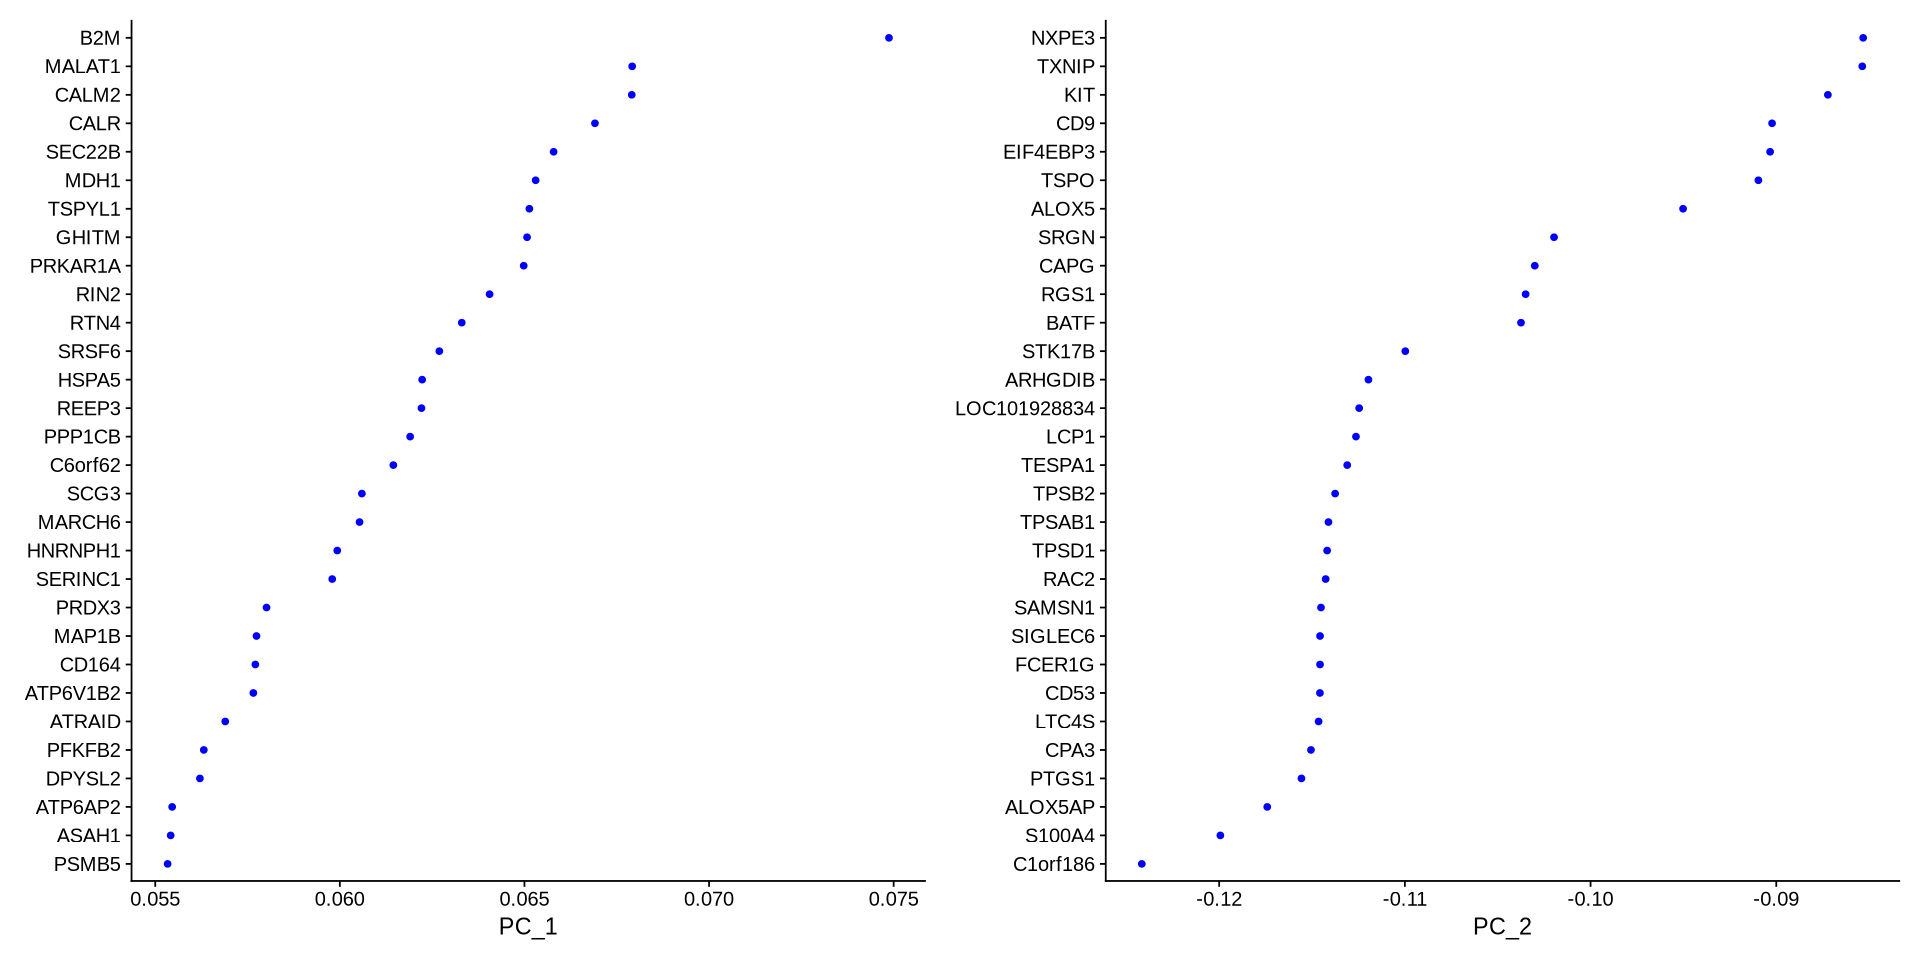

In [36]:
VizDimLoadings(so, dims = 1:2, reduction = "pca")

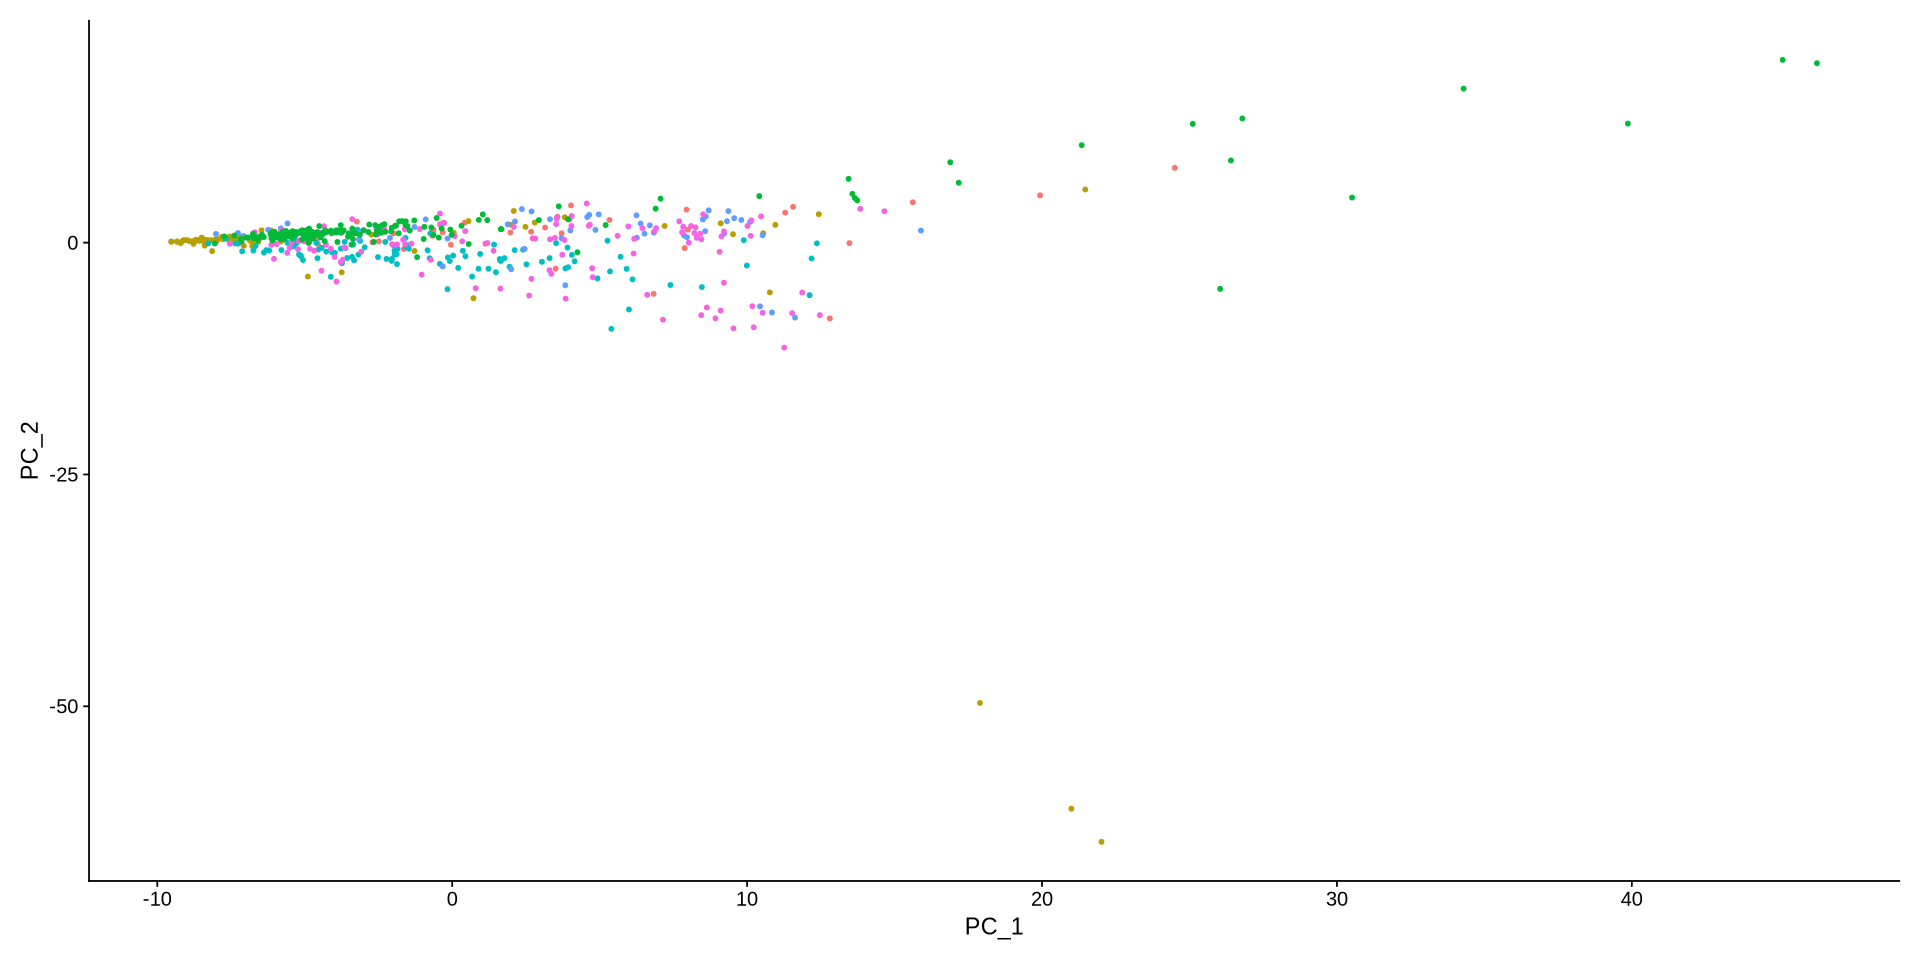

In [37]:
DimPlot(so, reduction = "pca") + NoLegend()

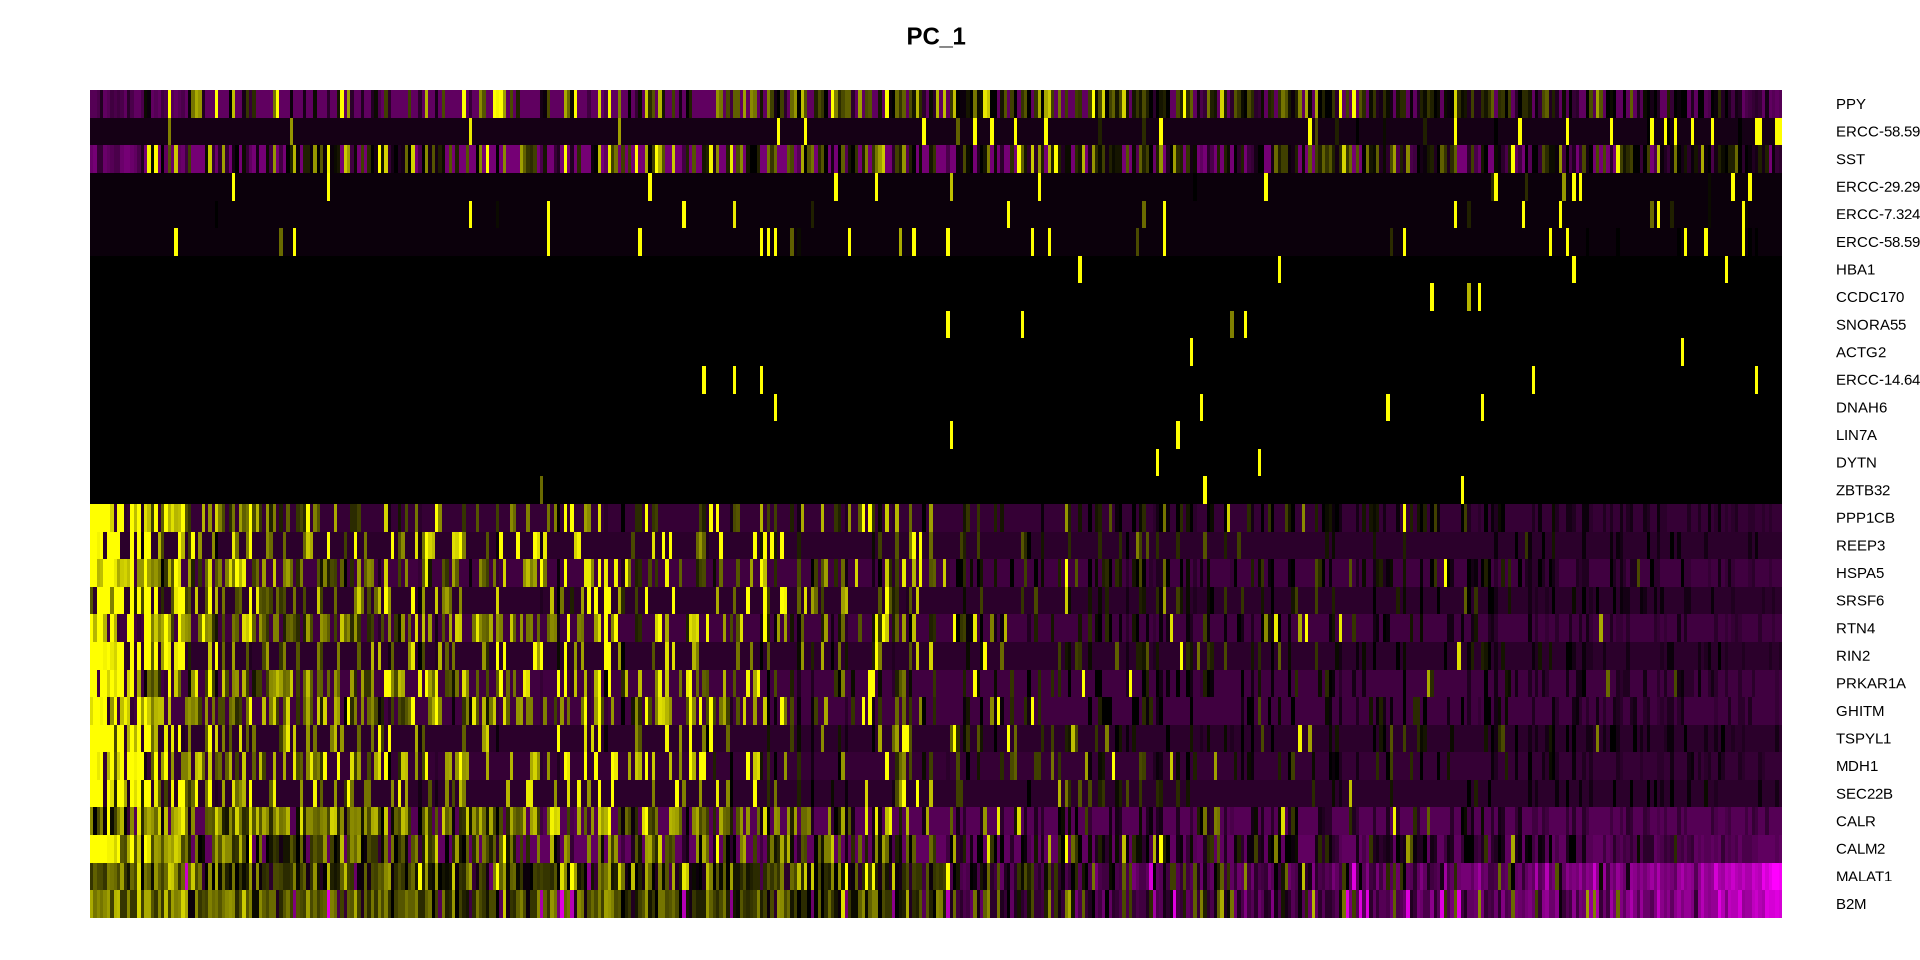

In [38]:
DimHeatmap(so, dims = 1, cells = 500, balanced = TRUE)

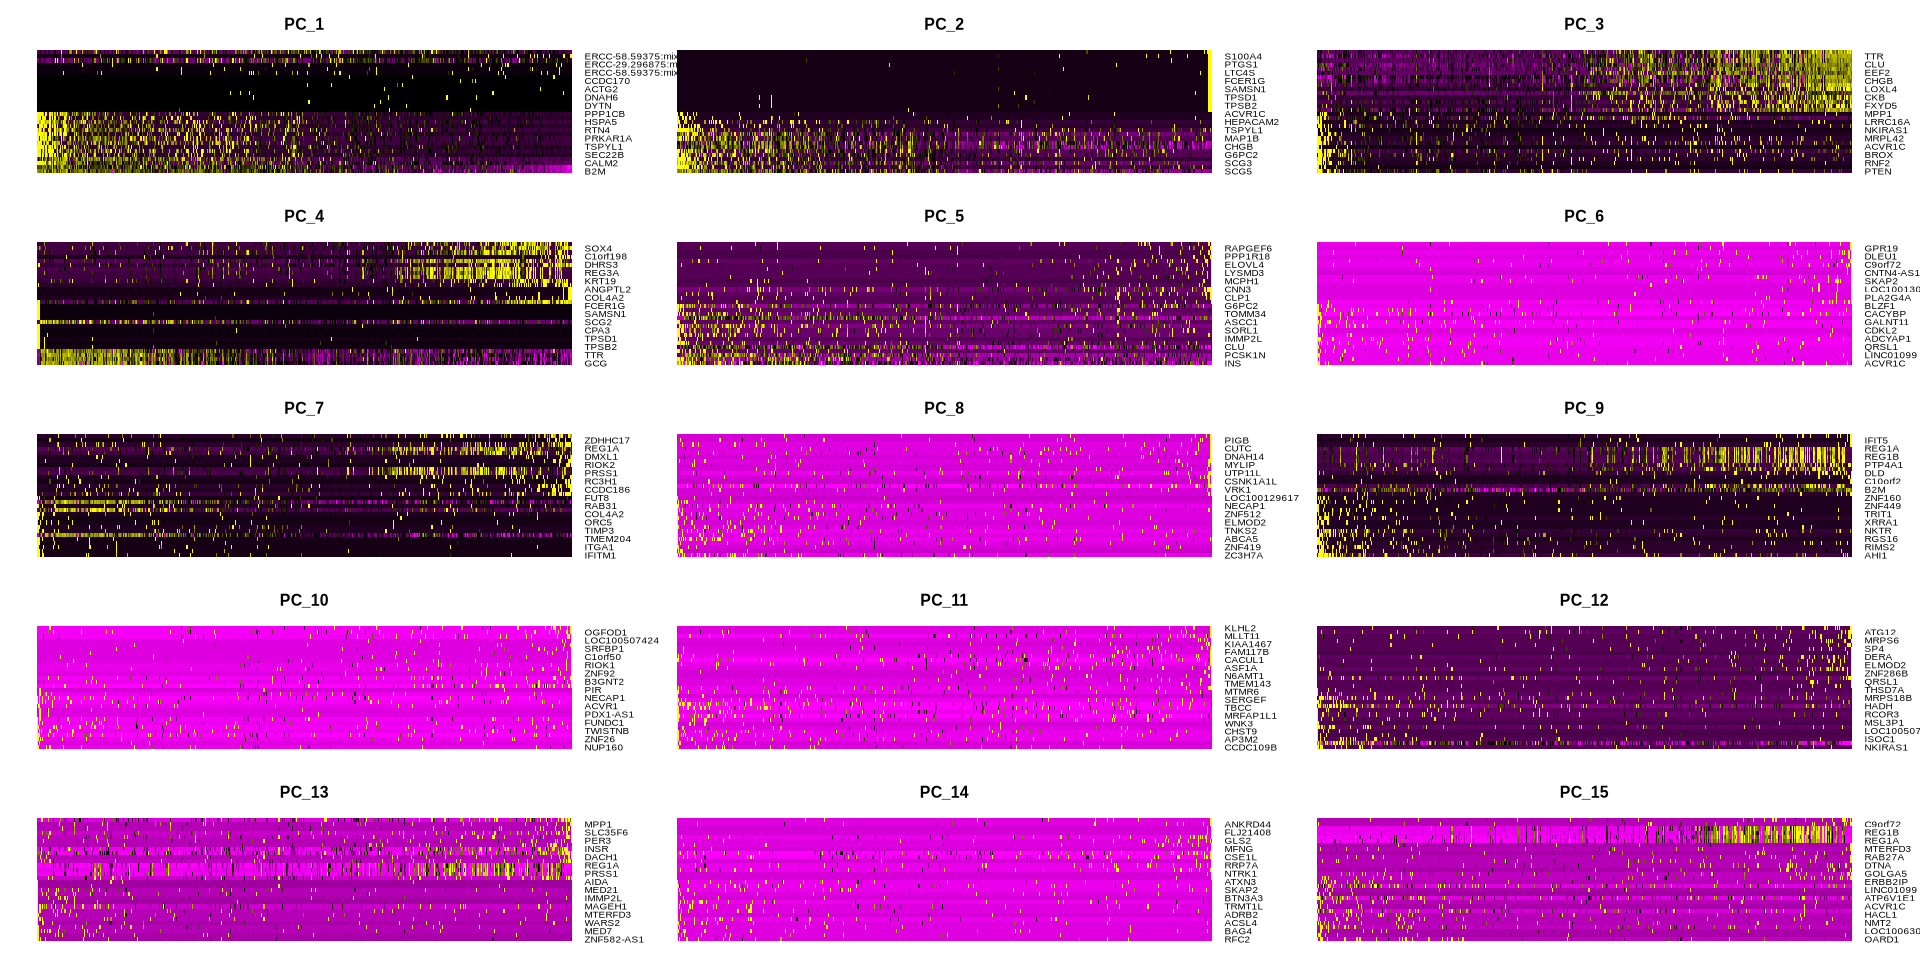

In [39]:
DimHeatmap(so, dims = 1:15, cells = 500, balanced = TRUE)

### Determining the dimensionality of the dataset

Looking at the Elbowplot, we can choose 10 PCs and it should be good. More PCs will just give us more noise.

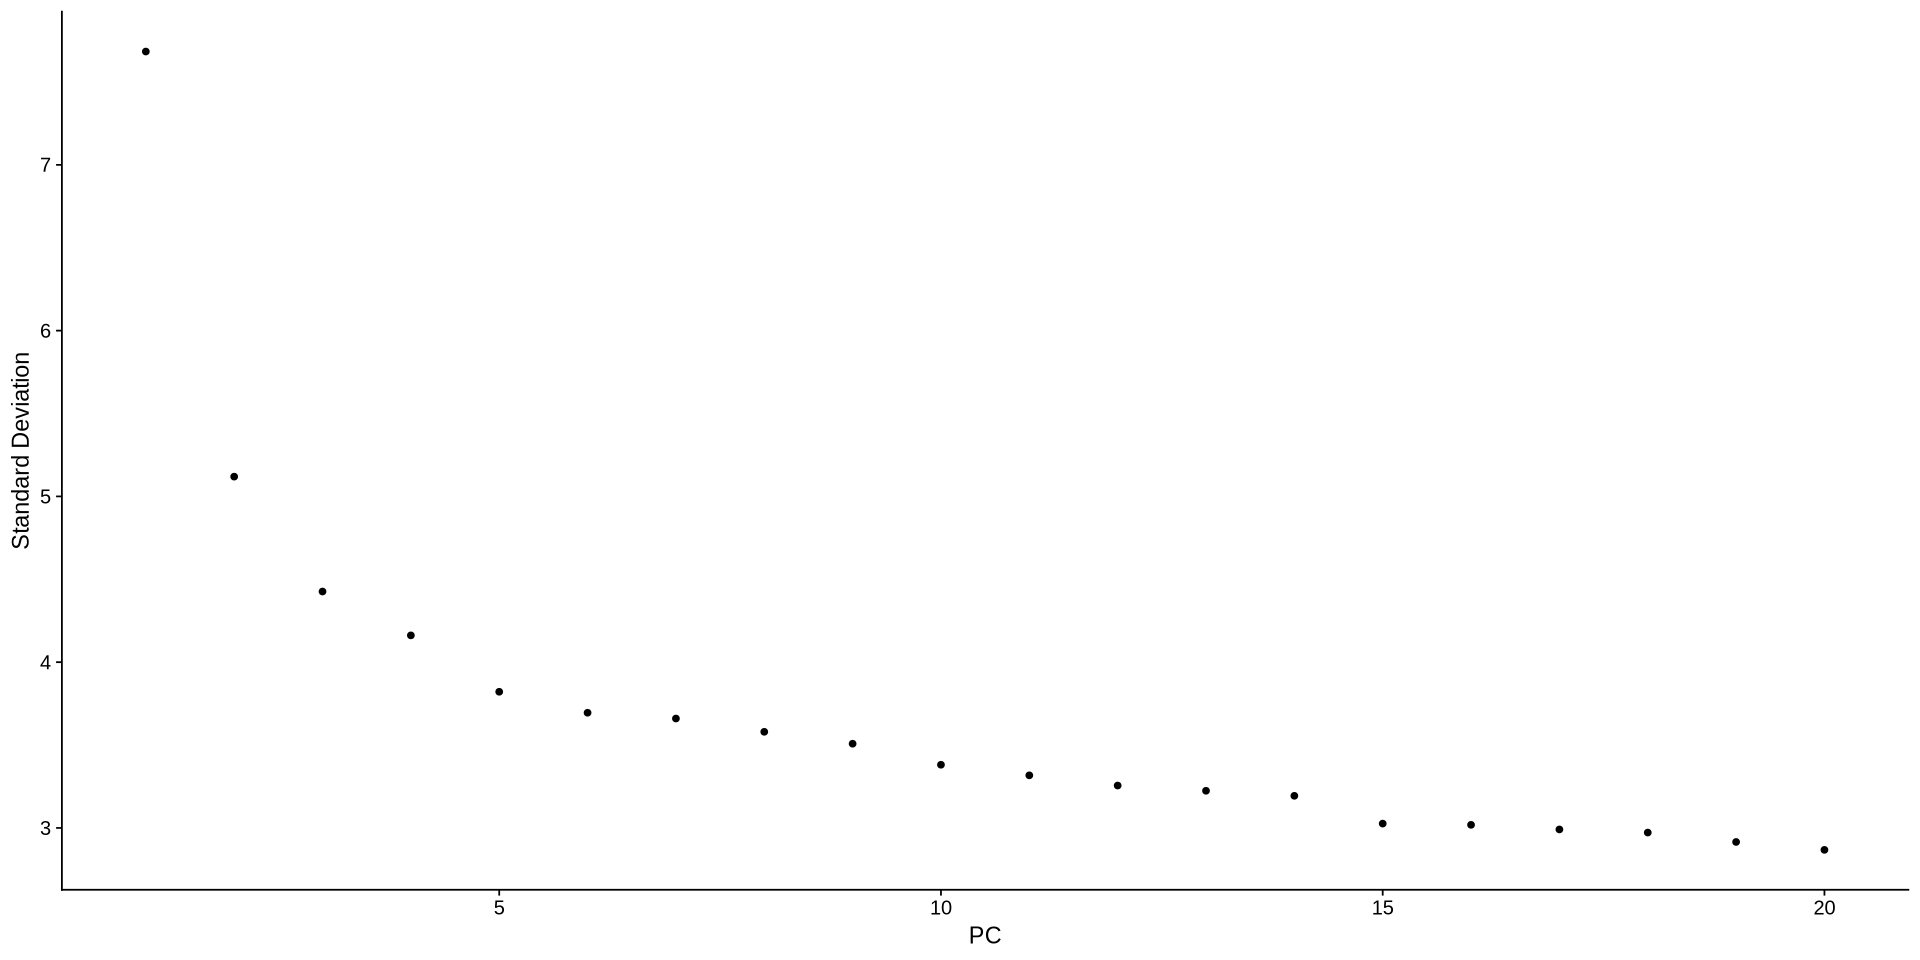

In [40]:
ElbowPlot(so)

In [41]:
so <- FindNeighbors(so, dims = 1:10)
so <- FindClusters(so, resolution = 0.5)
head(Idents(so), 5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 590
Number of edges: 18240

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8072
Number of communities: 5
Elapsed time: 0 seconds


AZ_A1 AZ_A3 AZ_A4 AZ_B6 AZ_B7 
    4     0     1     0     1 
Levels: 0 1 2 3 4

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
08:25:38 UMAP embedding parameters a = 0.9922 b = 1.112

08:25:38 Read 590 rows and found 10 numeric columns

08:25:38 Using Annoy for neighbor search, n_neighbors = 30

08:25:38 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

08:25:38 Writing NN index file to temp file /tmp/RtmpBw4D8s/file15635bf0b9d2

08:25:38 Searching Annoy index using 1 thread, search_k = 3000

08:25:38 Annoy recall = 100%

08:25:39 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

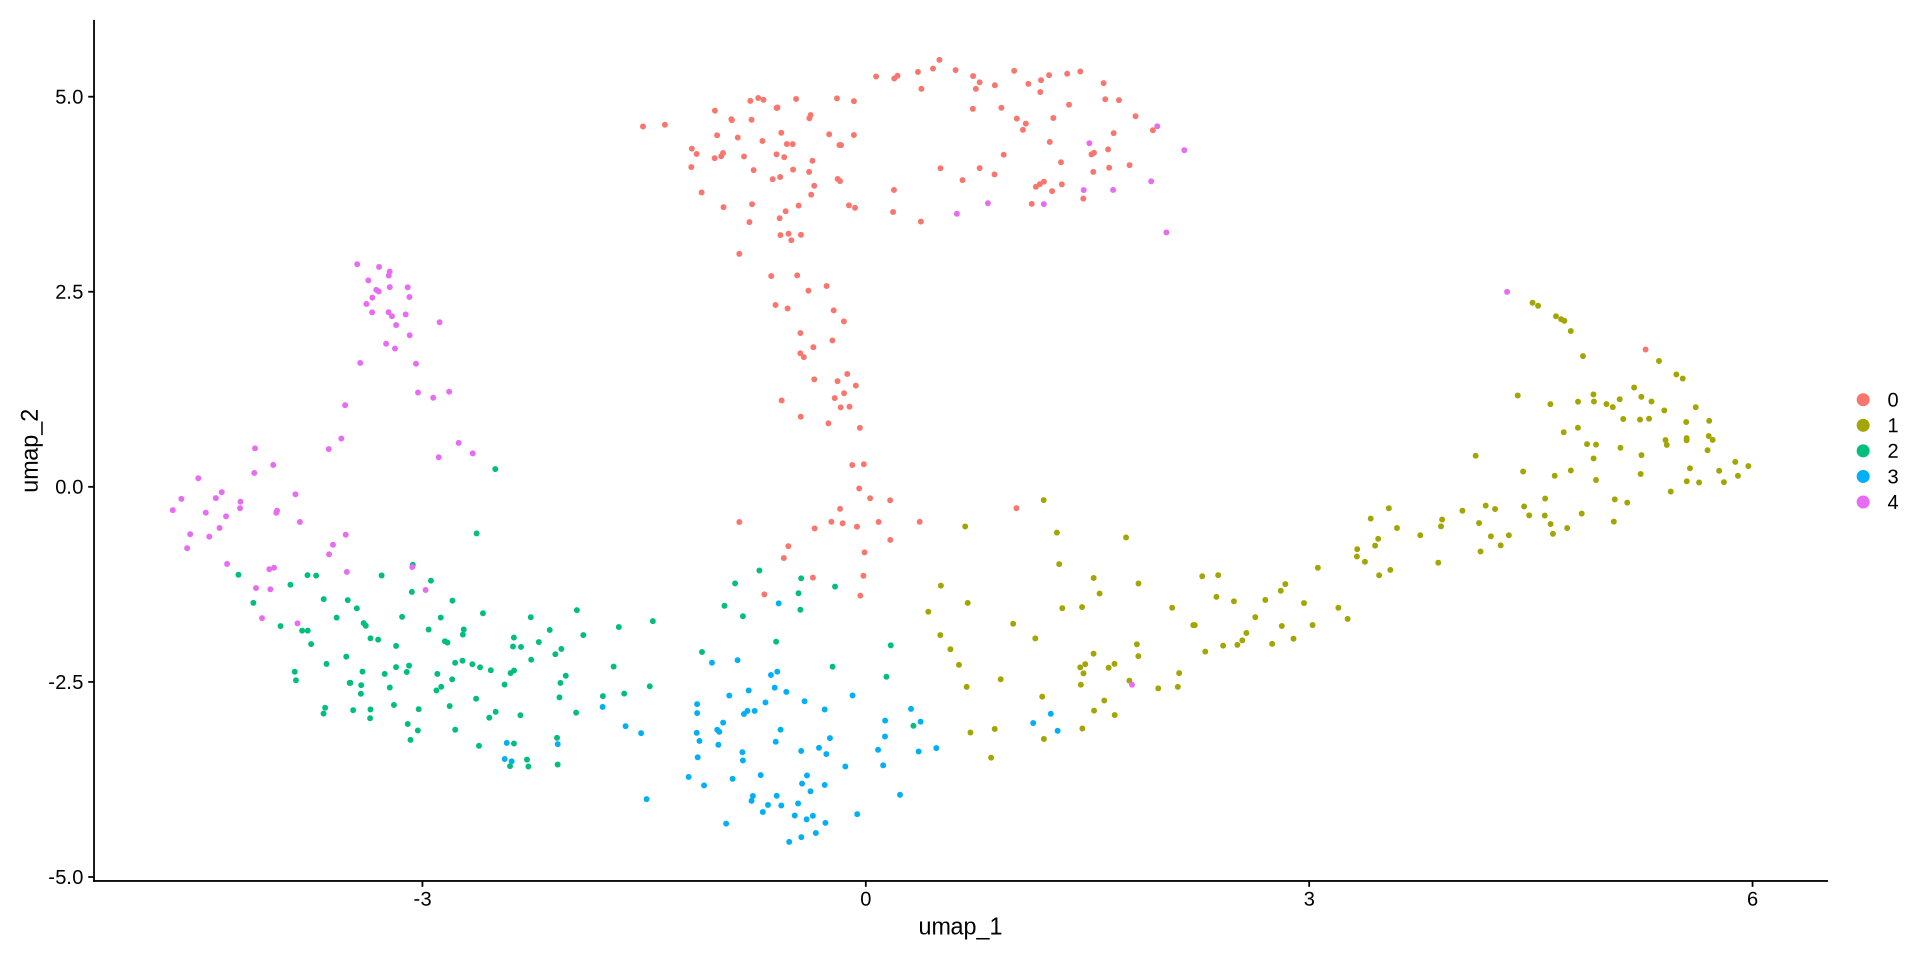

In [42]:
so <- RunUMAP(so, dims = 1:10)
DimPlot(so, reduction = 'umap')

In [43]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(so, only.pos = TRUE)
pbmc.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    head()

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4



p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster gene  
1 1.343505e-54 3.783003   1.000 0.972 2.690906e-50 0       TTR   
2 2.088589e-51 2.735592   0.988 0.907 4.183236e-47 0       CHGB  
3 3.245327e-47 3.139333   0.932 0.488 6.500066e-43 0       PCSK1N
4 4.194901e-47 3.597426   0.907 0.542 8.401968e-43 0       CHGA  
5 6.677288e-46 2.045059   0.963 0.881 1.337394e-41 0       GNAS  
6 1.910199e-43 2.388395   0.926 0.792 3.825938e-39 0       SCG5

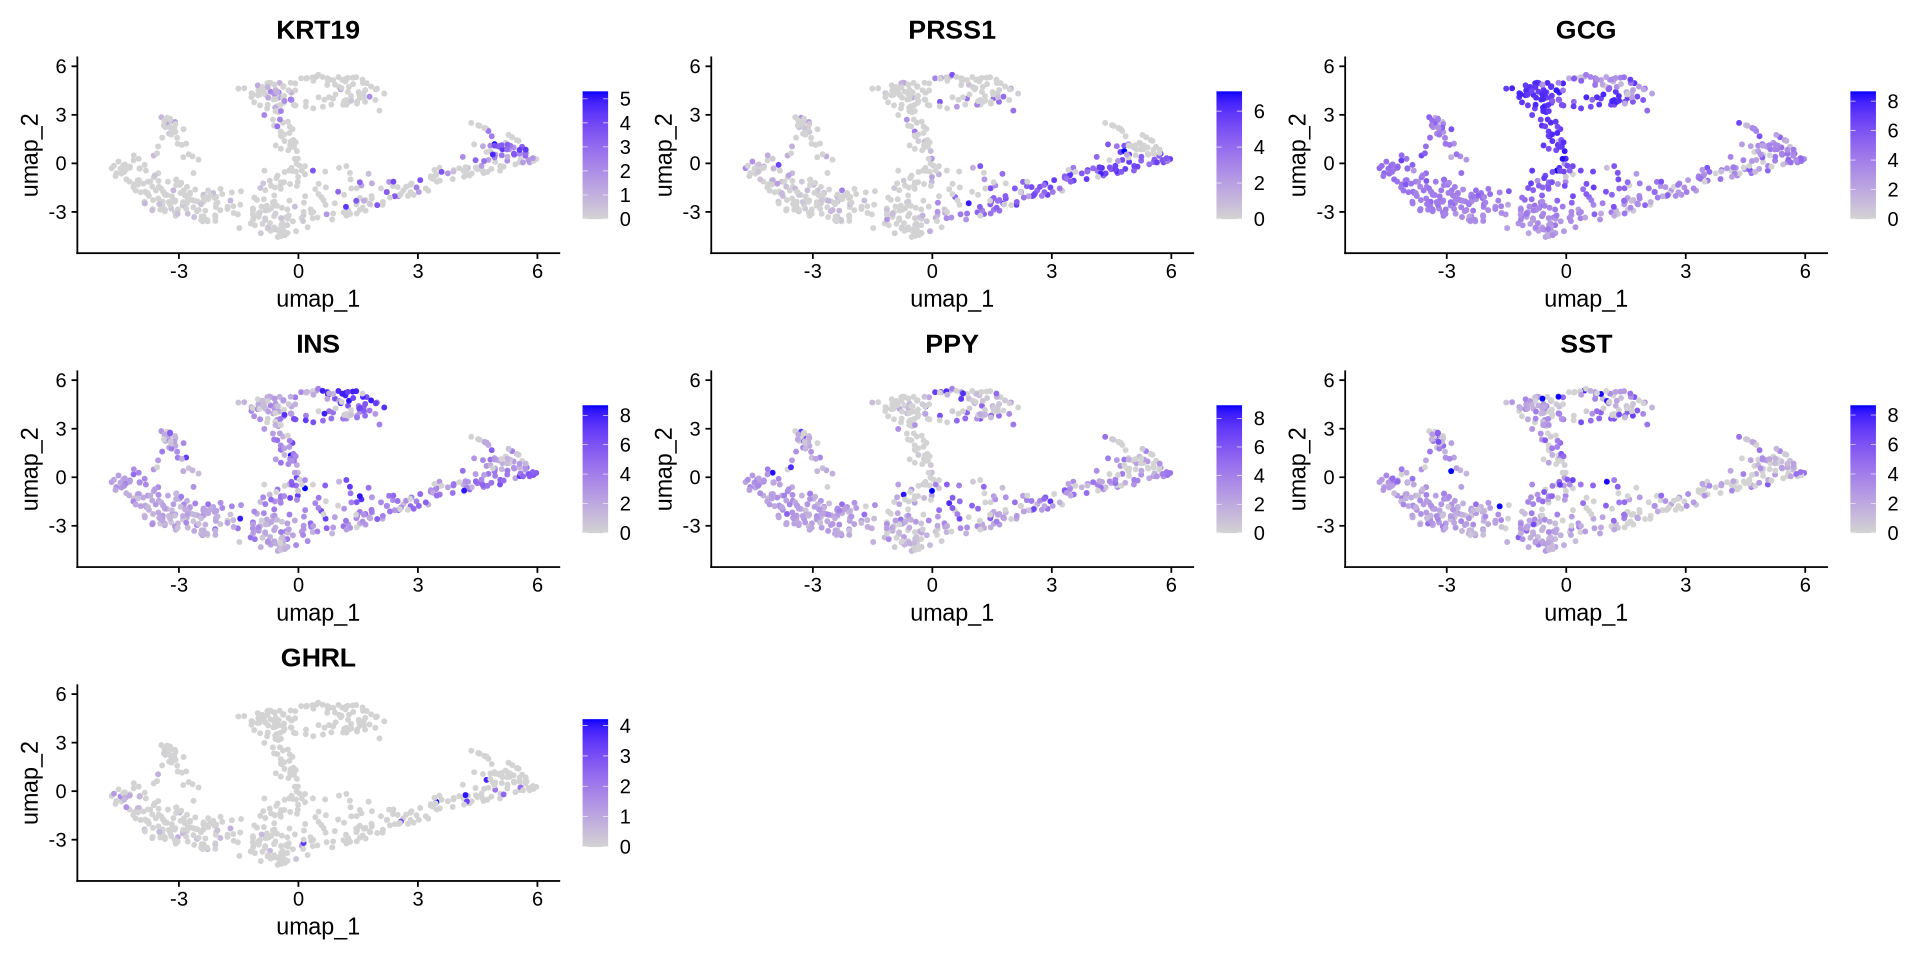

In [44]:
FeaturePlot(so, features = c("KRT19", "PRSS1", "GCG", "INS", "PPY", "SST", "GHRL"))

## baron data

### Getting baron data

In [45]:
# Hint:
# 1. Need to reorder the cells to make them match between count and cell.meta
# 2. Need to select the healthy individuals (and remove the T2D patients)

###########################################################################
# Paper: PMID 27667667
# Data link (available in paper):
# https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-5061
###########################################################################

baron1=read.csv('../data/GSE84133_RAW/GSM2230757_human1_umifm_counts.csv.gz')
baron2=read.csv('../data/GSE84133_RAW/GSM2230758_human2_umifm_counts.csv.gz')
baron3=read.csv('../data/GSE84133_RAW/GSM2230759_human3_umifm_counts.csv.gz')
baron4=read.csv('../data/GSE84133_RAW/GSM2230760_human4_umifm_counts.csv.gz')

In [46]:
head(baron1)

X                           barcode             assigned_cluster A1BG A1CF
1 human1_lib1.final_cell_0001 GATGACGGAC-GGTGGGAT acinar           0    4   
2 human1_lib1.final_cell_0002 GAGCGTTGCT-ACCTTCTT acinar           0    0   
3 human1_lib1.final_cell_0003 CTTACGGG-CCATTACT   acinar           0    0   
4 human1_lib1.final_cell_0004 GATGTACACG-TTAAACTG acinar           0    0   
5 human1_lib1.final_cell_0005 GAGATTGCGA-GTCGTCGT acinar           0    0   
6 human1_lib1.final_cell_0006 AATCCCACG-ATTCGACG  acinar           0    1   
  A2M A2ML1 A4GALT A4GNT AA06 ⋯ ZWILCH ZWINT ZXDA ZXDB ZXDC ZYG11B ZYX ZZEF1
1 0   0     0      0     0    ⋯ 0      0     0    0    0    0      2   0    
2 0   0     0      0     0    ⋯ 0      0     0    0    0    1      4   0    
3 0   0     0      0     0    ⋯ 0      0     0    0    0    0      0   0    
4 0   0     0      0     0    ⋯ 1      0     0    0    0    1      3   1    
5 0   0     0      0     0    ⋯ 0      0     0    0    0    0      1   0    
6 0   0     0      0     0    ⋯ 0      0     0    0    0    0      1   1    
  ZZZ3 pk
1 0    1 
2 1    0 
3 0    0 
4 0    0 
5 0    1 
6 1    0

In [47]:
# Check that the columns are the same before combining rows
all(colnames(baron1)==colnames(baron2))
all(colnames(baron1)==colnames(baron3))
all(colnames(baron1)==colnames(baron4))

[1] TRUE

[1] TRUE

[1] TRUE

In [48]:
baron=rbind(baron1, baron2, baron3, baron4)
rm(baron1,baron2,baron3,baron4)
head(baron)

X                           barcode             assigned_cluster A1BG A1CF
1 human1_lib1.final_cell_0001 GATGACGGAC-GGTGGGAT acinar           0    4   
2 human1_lib1.final_cell_0002 GAGCGTTGCT-ACCTTCTT acinar           0    0   
3 human1_lib1.final_cell_0003 CTTACGGG-CCATTACT   acinar           0    0   
4 human1_lib1.final_cell_0004 GATGTACACG-TTAAACTG acinar           0    0   
5 human1_lib1.final_cell_0005 GAGATTGCGA-GTCGTCGT acinar           0    0   
6 human1_lib1.final_cell_0006 AATCCCACG-ATTCGACG  acinar           0    1   
  A2M A2ML1 A4GALT A4GNT AA06 ⋯ ZWILCH ZWINT ZXDA ZXDB ZXDC ZYG11B ZYX ZZEF1
1 0   0     0      0     0    ⋯ 0      0     0    0    0    0      2   0    
2 0   0     0      0     0    ⋯ 0      0     0    0    0    1      4   0    
3 0   0     0      0     0    ⋯ 0      0     0    0    0    0      0   0    
4 0   0     0      0     0    ⋯ 1      0     0    0    0    1      3   1    
5 0   0     0      0     0    ⋯ 0      0     0    0    0    0      1   0    
6 0   0     0      0     0    ⋯ 0      0     0    0    0    0      1   1    
  ZZZ3 pk
1 0    1 
2 1    0 
3 0    0 
4 0    0 
5 0    1 
6 1    0

In [49]:
cell.meta=baron[,1:3]
colnames(cell.meta)[1]='cell'
head(cell.meta)

cell                        barcode             assigned_cluster
1 human1_lib1.final_cell_0001 GATGACGGAC-GGTGGGAT acinar          
2 human1_lib1.final_cell_0002 GAGCGTTGCT-ACCTTCTT acinar          
3 human1_lib1.final_cell_0003 CTTACGGG-CCATTACT   acinar          
4 human1_lib1.final_cell_0004 GATGTACACG-TTAAACTG acinar          
5 human1_lib1.final_cell_0005 GAGATTGCGA-GTCGTCGT acinar          
6 human1_lib1.final_cell_0006 AATCCCACG-ATTCGACG  acinar

In [50]:
cell.meta$individual=substr(cell.meta$cell, start=1, stop=6)
head(cell.meta, 3)

cell                        barcode             assigned_cluster individual
1 human1_lib1.final_cell_0001 GATGACGGAC-GGTGGGAT acinar           human1    
2 human1_lib1.final_cell_0002 GAGCGTTGCT-ACCTTCTT acinar           human1    
3 human1_lib1.final_cell_0003 CTTACGGG-CCATTACT   acinar           human1

In [51]:
table(cell.meta$individual)


human1 human2 human3 human4 
  1937   1724   3605   1303 

In [52]:
count=as.matrix(baron[,-(1:3)])
rm(baron)
head(count)

A1BG A1CF A2M A2ML1 A4GALT A4GNT AA06 AAAS AACS AACSP1 ⋯ ZWILCH ZWINT ZXDA
[1,] 0    4    0   0     0      0     0    0    0    0      ⋯ 0      0     0   
[2,] 0    0    0   0     0      0     0    0    2    0      ⋯ 0      0     0   
[3,] 0    0    0   0     0      0     0    0    0    0      ⋯ 0      0     0   
[4,] 0    0    0   0     0      0     0    1    0    0      ⋯ 1      0     0   
[5,] 0    0    0   0     0      0     0    0    0    0      ⋯ 0      0     0   
[6,] 0    1    0   0     0      0     0    0    2    0      ⋯ 0      0     0   
     ZXDB ZXDC ZYG11B ZYX ZZEF1 ZZZ3 pk
[1,] 0    0    0      2   0     0    1 
[2,] 0    0    1      4   0     1    0 
[3,] 0    0    0      0   0     0    0 
[4,] 0    0    1      3   1     0    0 
[5,] 0    0    0      1   0     0    1 
[6,] 0    0    0      1   1     1    0

In [53]:
rownames(count)=cell.meta$cell
rownames(cell.meta)=cell.meta$cell
colnames(cell.meta)[3]='celltype'
head(count, 3)

A1BG A1CF A2M A2ML1 A4GALT A4GNT AA06 AAAS AACS
human1_lib1.final_cell_0001 0    4    0   0     0      0     0    0    0   
human1_lib1.final_cell_0002 0    0    0   0     0      0     0    0    2   
human1_lib1.final_cell_0003 0    0    0   0     0      0     0    0    0   
                            AACSP1 ⋯ ZWILCH ZWINT ZXDA ZXDB ZXDC ZYG11B ZYX
human1_lib1.final_cell_0001 0      ⋯ 0      0     0    0    0    0      2  
human1_lib1.final_cell_0002 0      ⋯ 0      0     0    0    0    1      4  
human1_lib1.final_cell_0003 0      ⋯ 0      0     0    0    0    0      0  
                            ZZEF1 ZZZ3 pk
human1_lib1.final_cell_0001 0     0    1 
human1_lib1.final_cell_0002 0     1    0 
human1_lib1.final_cell_0003 0     0    0

In [54]:
dim(count)

[1]  8569 20125

In [55]:
df2 = count

### Quality control

No duplicate rows or columns.

In [56]:
sum(duplicated(rownames(df2)))

[1] 0

In [57]:
sum(duplicated(colnames(df2)))

[1] 0

In [58]:
so2 <- CreateSeuratObject(counts = t(df2), project = "midterm2", min.cells = 3, min.features = 200)
so2

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”


An object of class Seurat 
16359 features across 8569 samples within 1 assay 
Active assay: RNA (16359 features, 0 variable features)
 1 layer present: counts

There is no mitochondrial data either.

In [59]:
sum(PercentageFeatureSet(so2, pattern = "^MT-"))

[1] 0

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


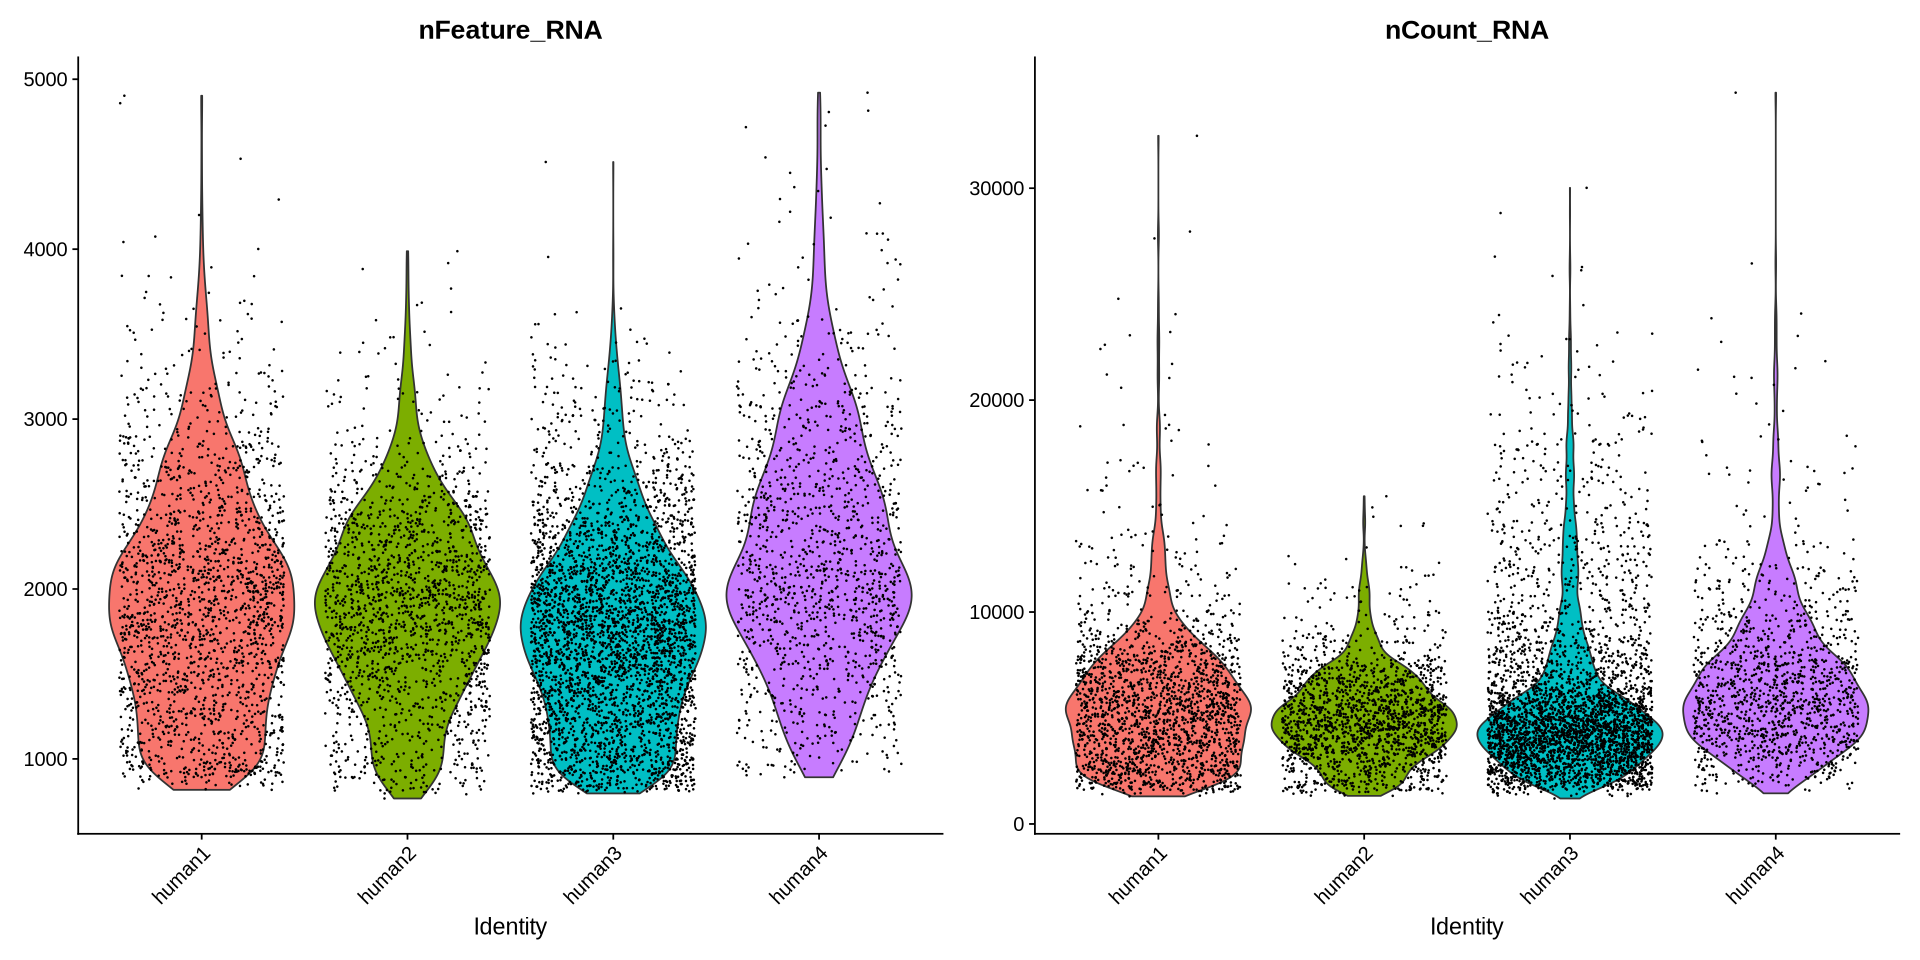

In [60]:
VlnPlot(so2, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

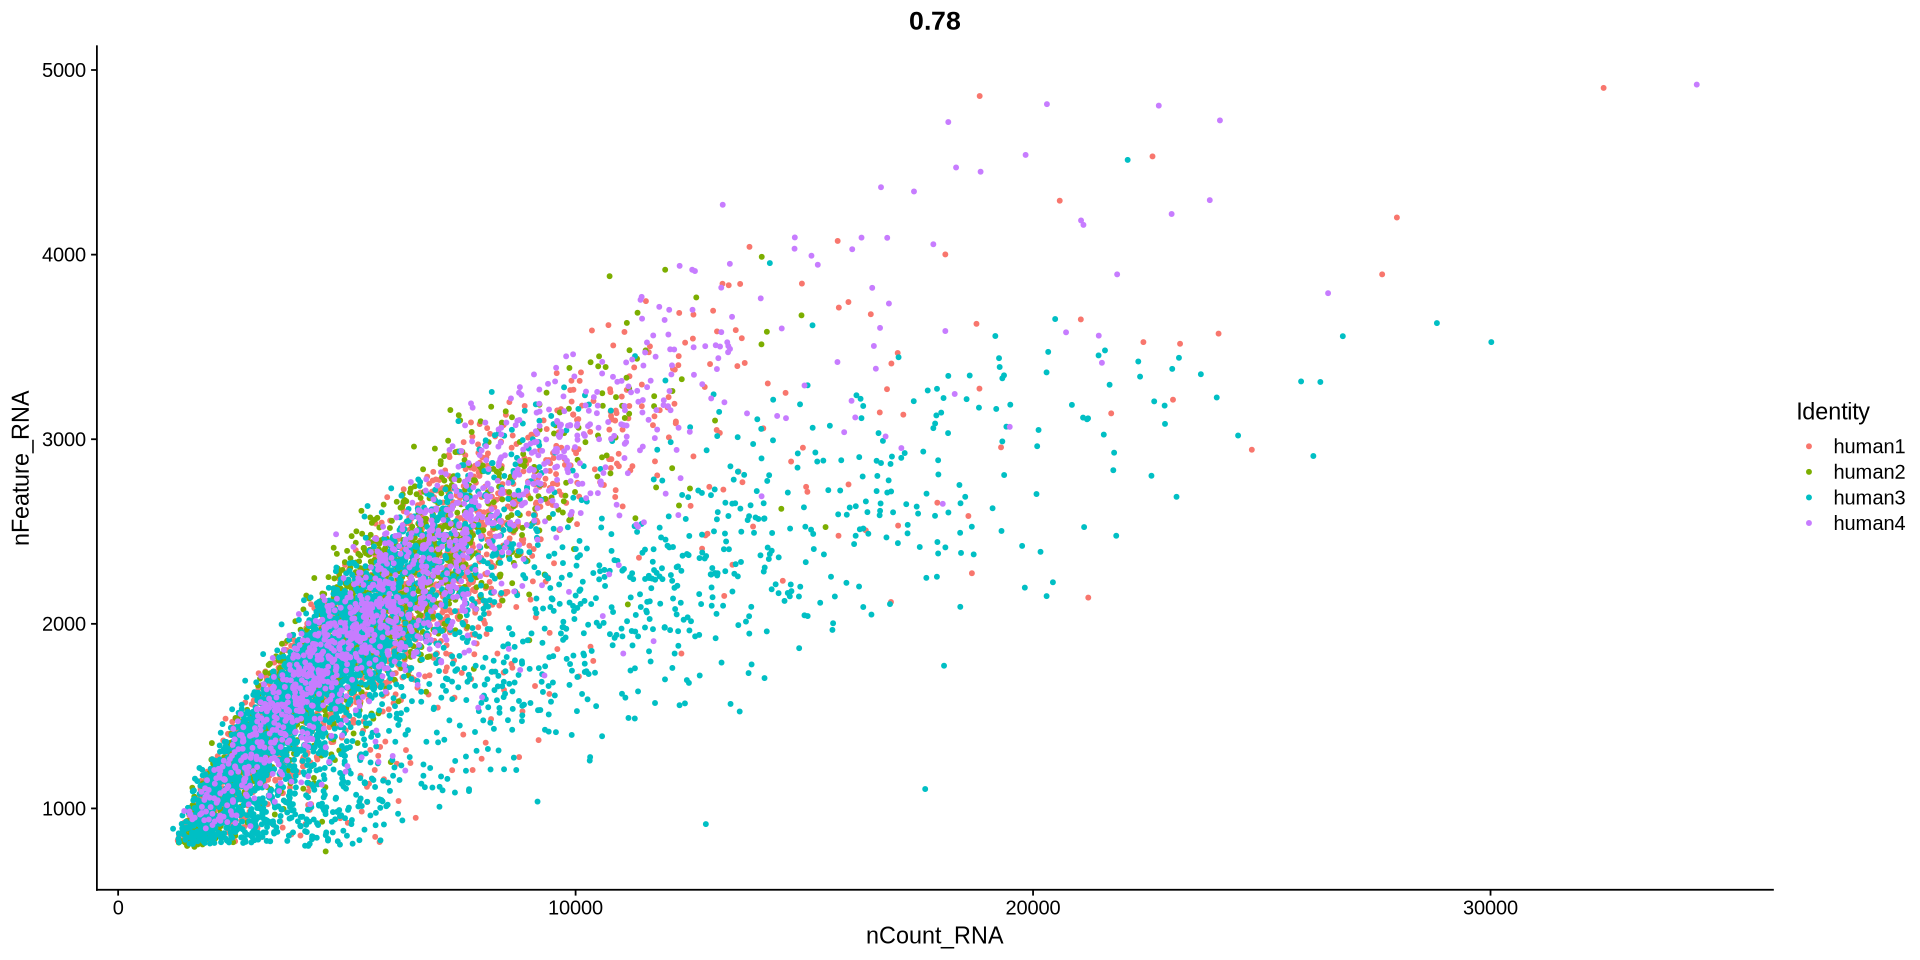

In [61]:
FeatureScatter(so2, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

In [62]:
so2 = subset(so2, subset = nFeature_RNA > 200 & nFeature_RNA < 2500)

### Normalize the data

In [63]:
so2 <- NormalizeData(so2)
so2

Normalizing layer: counts



An object of class Seurat 
16359 features across 7242 samples within 1 assay 
Active assay: RNA (16359 features, 0 variable features)
 2 layers present: counts, data

### Highly variable features

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


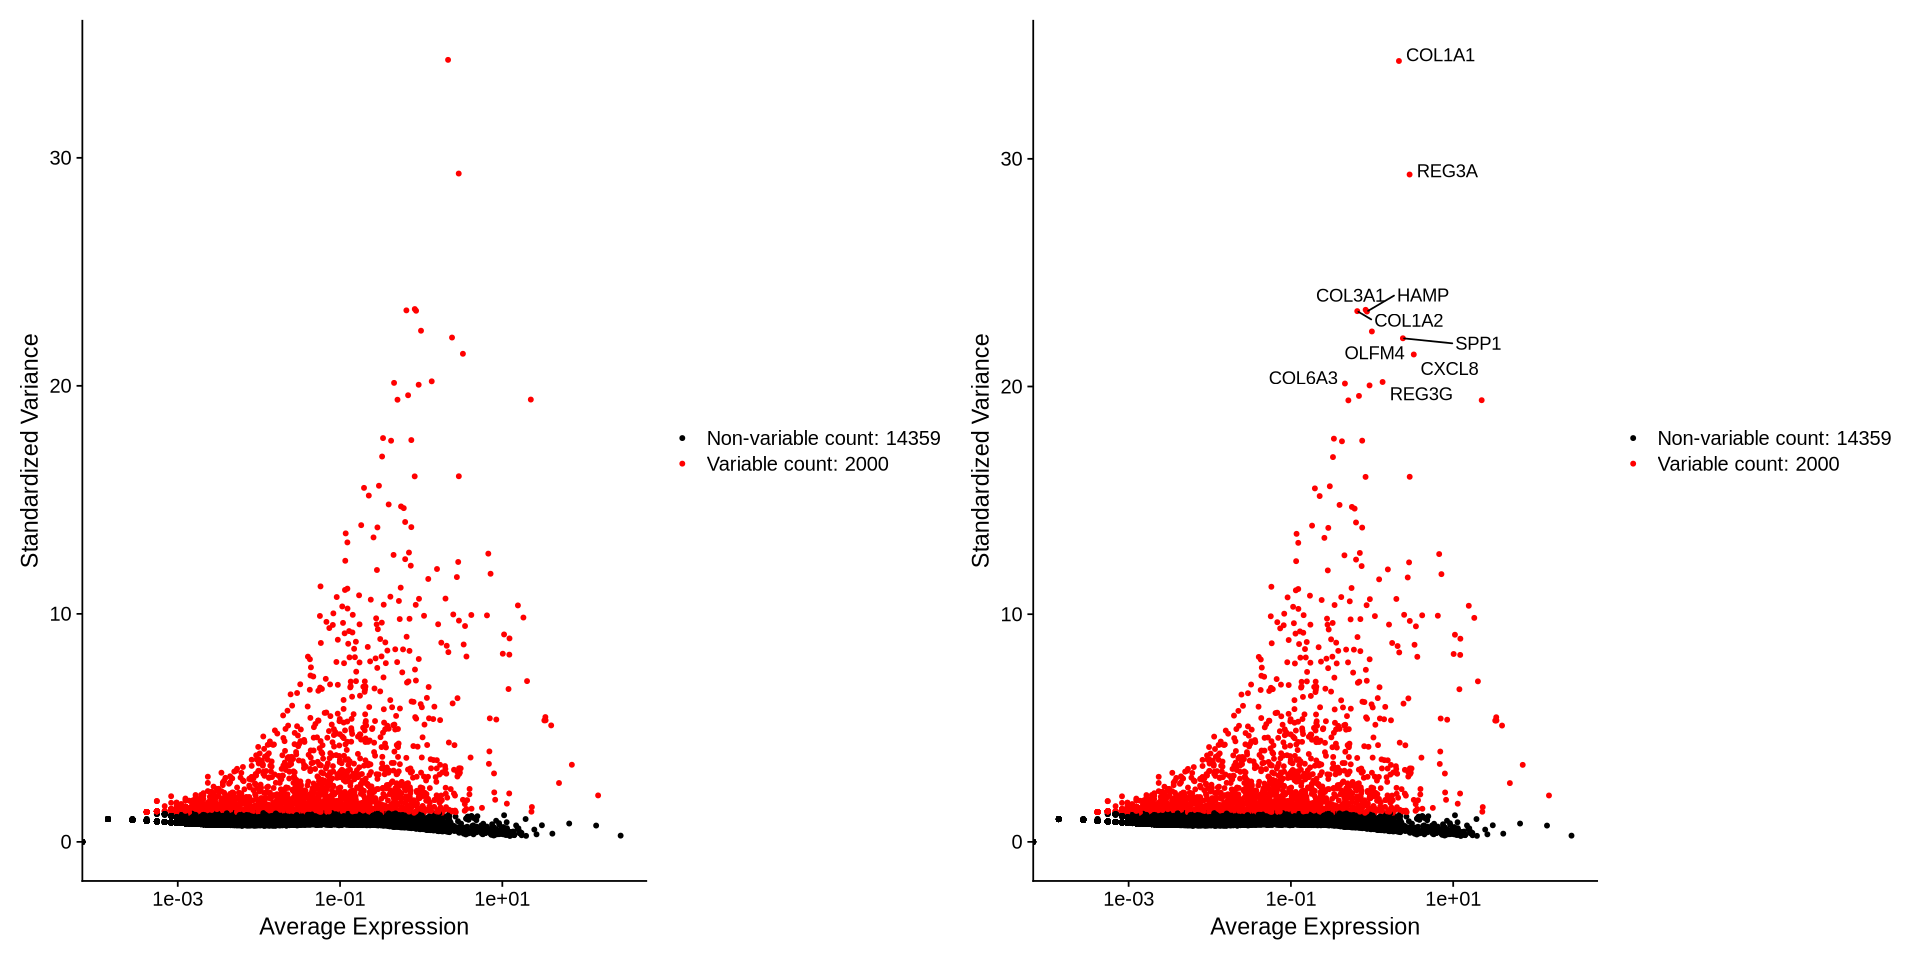

In [64]:
so2 <- FindVariableFeatures(so2, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10_2 <- head(VariableFeatures(so2), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(so2)
plot2 <- LabelPoints(plot = plot1, points = top10_2, repel = TRUE)
plot1 + plot2

### Scaling data

In [65]:
all.genes <- rownames(so2)
so2 <- ScaleData(so2, features = all.genes)

Centering and scaling data matrix



### PCA

PC_ 1 
Positive:  IFITM3, PMEPA1, COL18A1, IFITM2, TMSB10, ITGA5, MSN, MMP14, SOX4, LGALS1 
	   CDC42EP1, SPARC, ZFP36L1, FLNA, PXDN, ENG, YBX3, HSPG2, COL4A1, SERPINH1 
	   SERPING1, RHOC, MYH9, TMSB4X, S100A16, IFITM1, CEBPB, SERPINE1, TUBB6, CLIC4 
Negative:  CHGA, CHGB, SCG2, PPP1R1A, VGF, PCSK2, PAX6, GAD2, UCHL1, SLC30A8 
	   NEUROD1, ERO1B, ABCC8, GNG4, TMEM176B, SEC11C, C1QL1, TMEM176A, PAPSS2, PCSK1 
	   GCH1, C2CD4A, UCN3, PCP4, MAFB, ALDH1A1, CFC1, STX1A, RASD1, PAK3 
PC_ 2 
Positive:  SPARC, COL4A1, ENG, IGFBP4, PXDN, COL6A2, COL15A1, BGN, PDGFRB, ITGA1 
	   COL3A1, TIMP1, COL1A2, ADAMTS4, LAMA4, LRRC32, HTRA3, CYGB, COL6A1, AEBP1 
	   TCF4, COL1A1, TIMP3, SERPINE1, HIC1, ANGPTL2, PLVAP, COL5A3, IGFBP7, MFGE8 
Negative:  SERPINA3, CD24, CD44, KRT18, KRT8, TACSTD2, SPINK1, CTRB1, SDC4, PDZK1IP1 
	   PRSS2, PRSS1, CPA2, CTRB2, CELA3A, IL32, KRT7, CELA3B, REG1A, PLA2G1B 
	   CPA1, CTRC, PRSS8, CLPS, LCN2, PNLIPRP1, CPB1, KLK1, CELA2A, SYCN 
PC_ 3 
Positive:  PDGFRB, COL3A1, CO

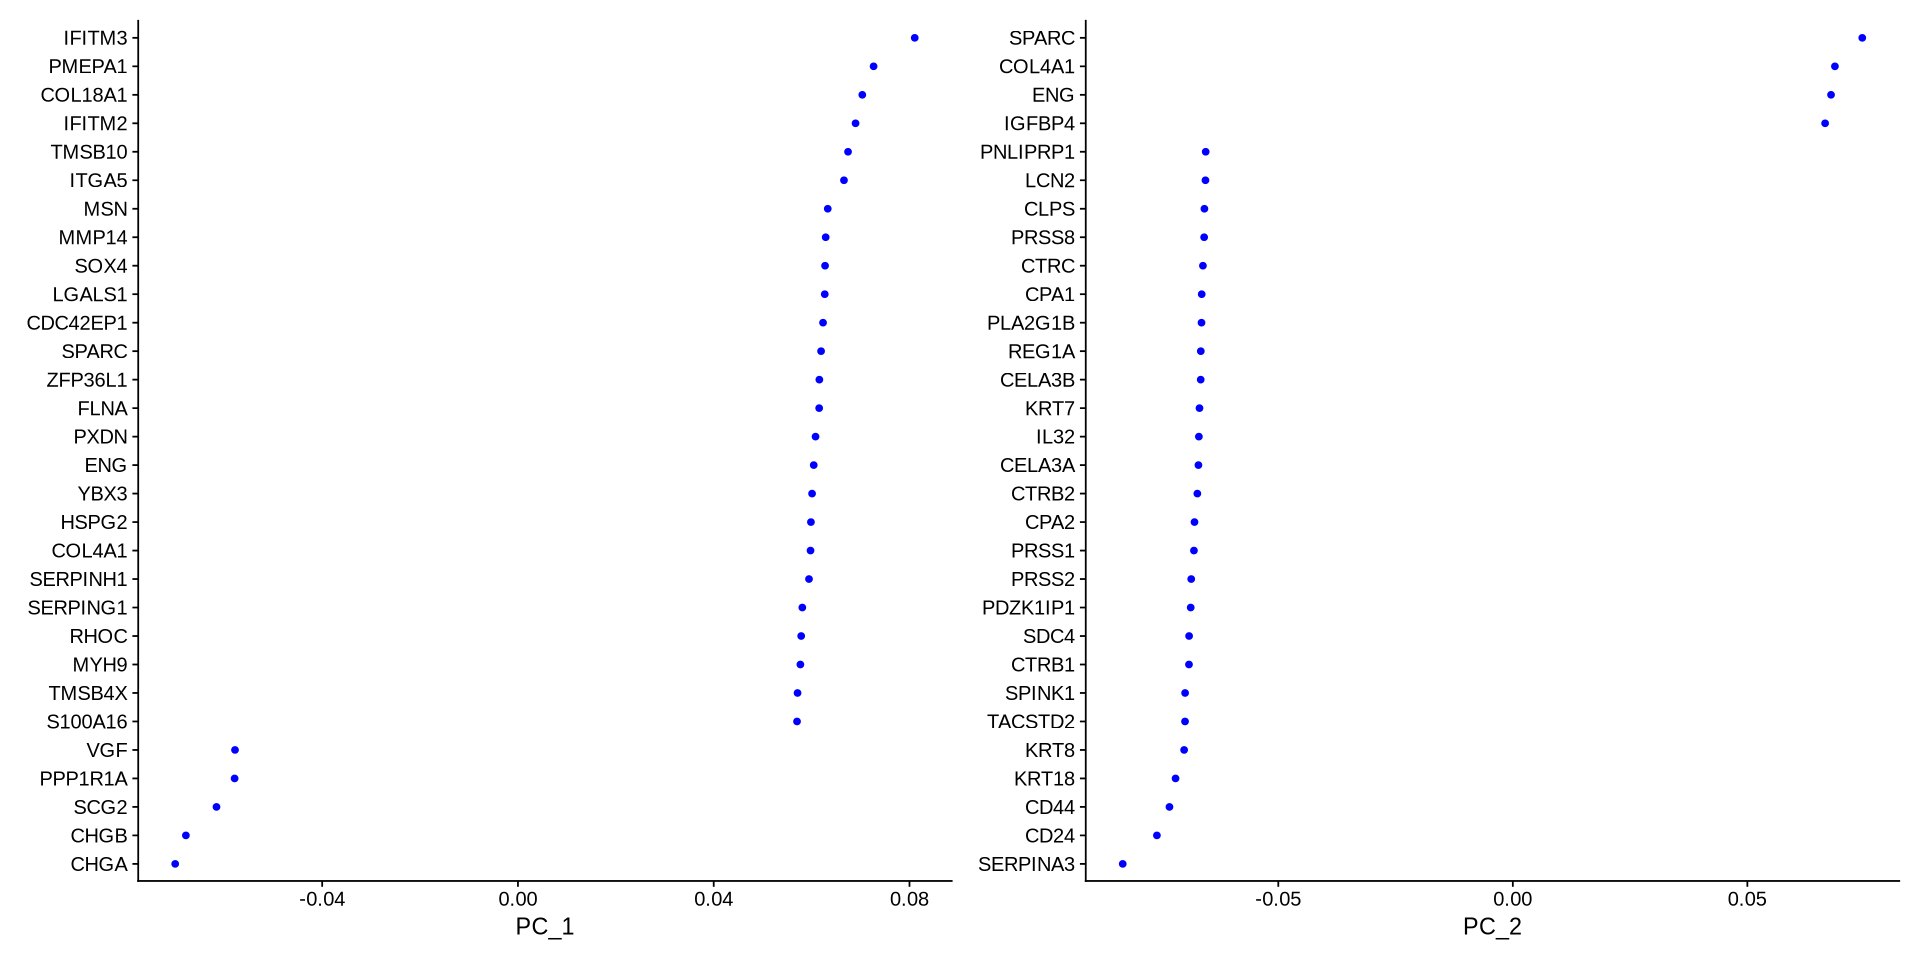

In [66]:
so2 <- RunPCA(so2, features = VariableFeatures(object = so2))
VizDimLoadings(so2, dims = 1:2, reduction = "pca")

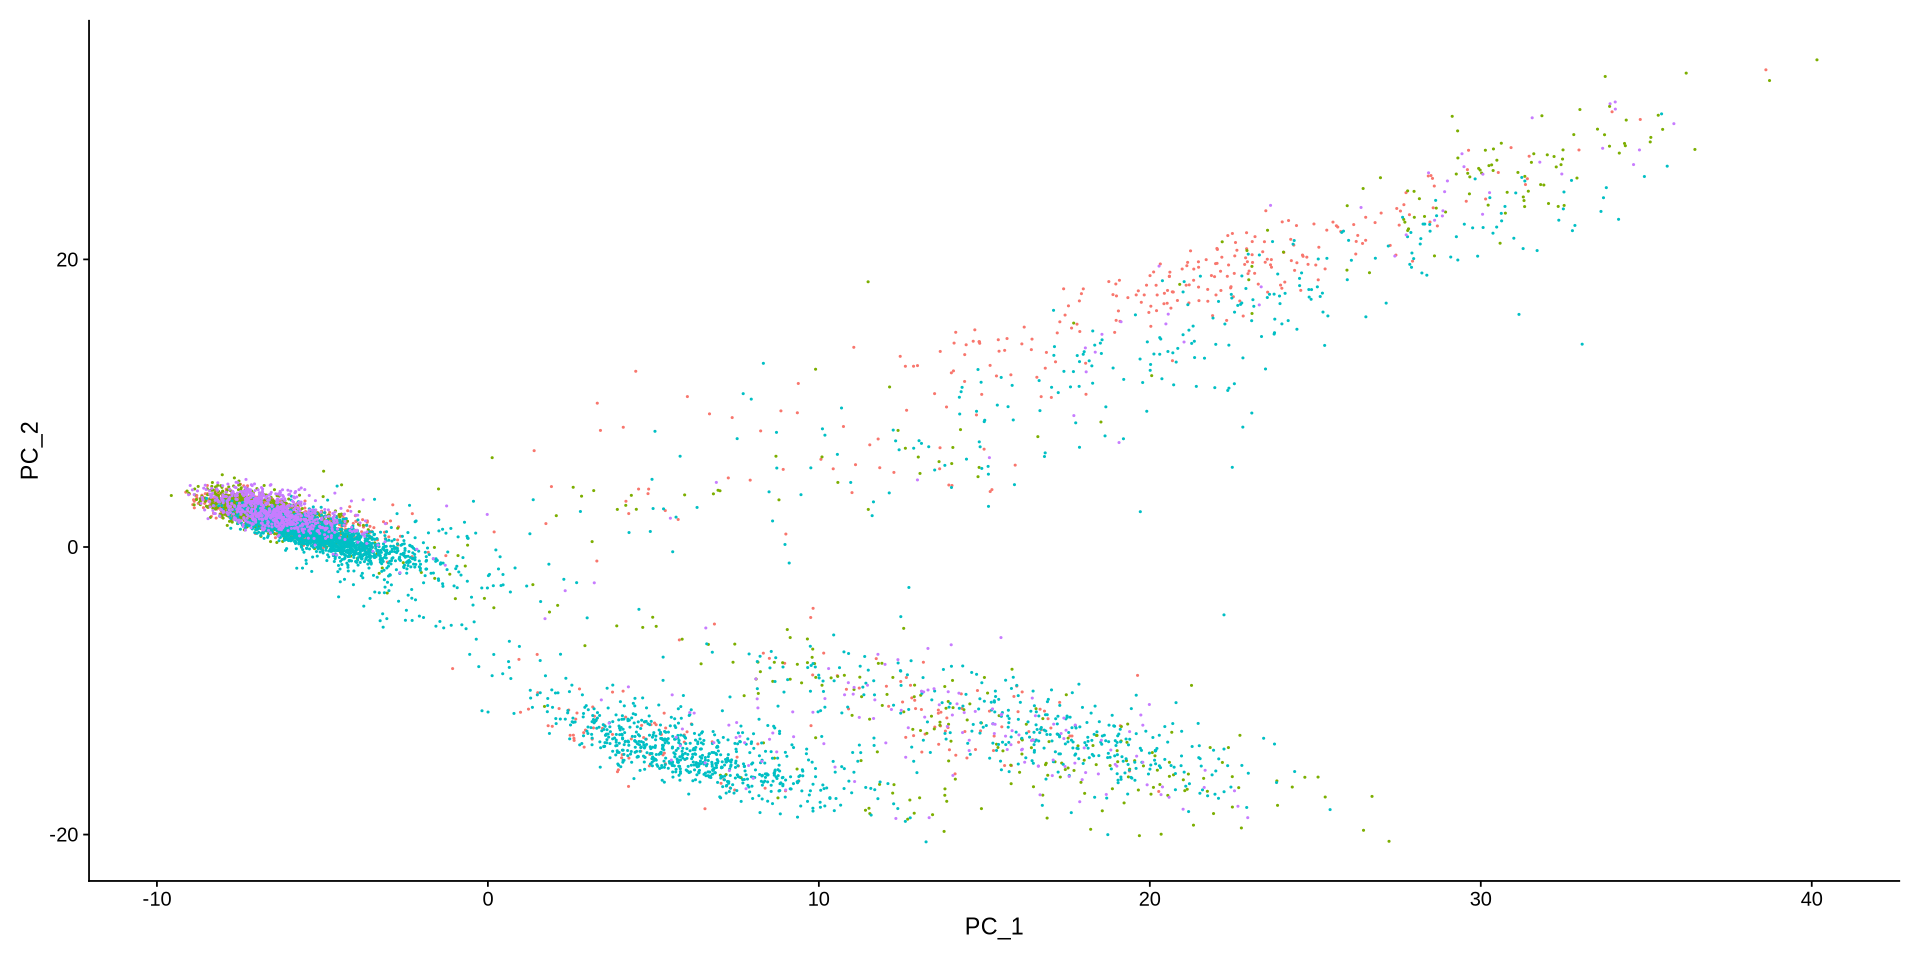

In [67]:
DimPlot(so2, reduction = "pca") + NoLegend()

### Determining the dimensionality of the dataset

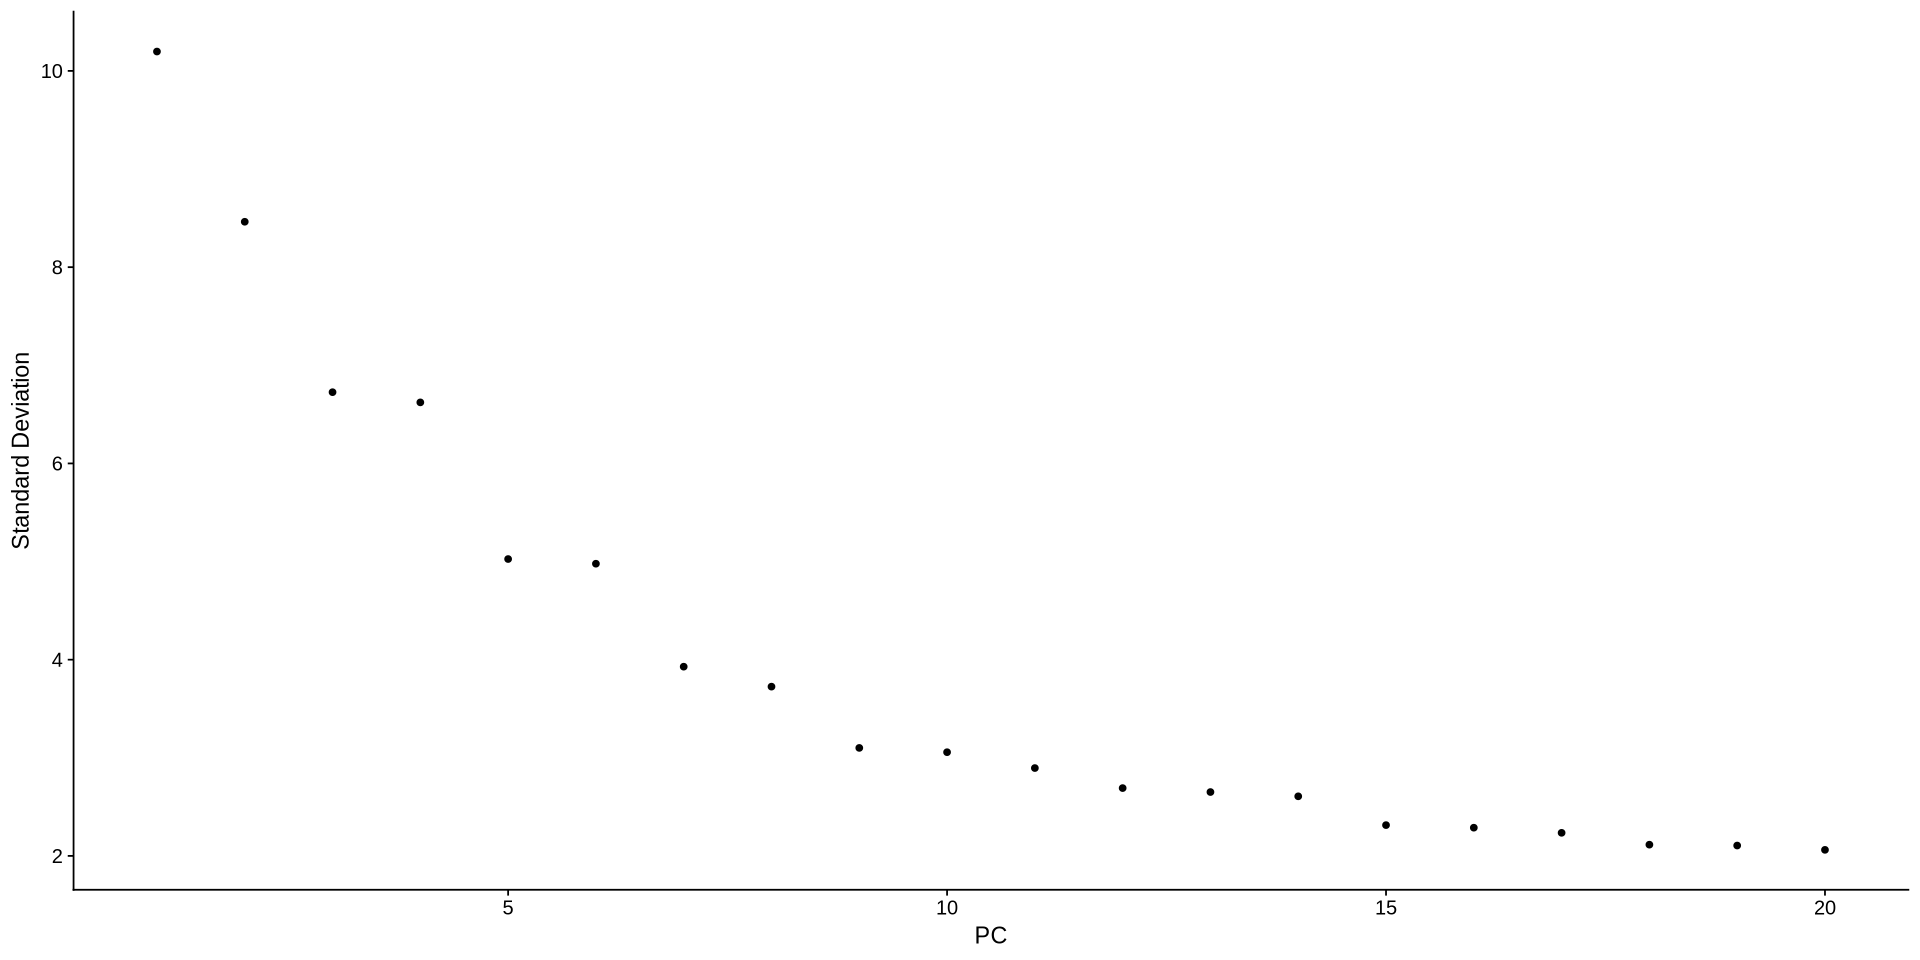

In [68]:
ElbowPlot(so2)

In [69]:
so2 <- FindNeighbors(so2, dims = 1:10)
so2 <- FindClusters(so2, resolution = 0.5)
head(Idents(so2), 5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7242
Number of edges: 241535

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9195
Number of communities: 12
Elapsed time: 0 seconds


human1_lib1.final_cell_0003 human1_lib1.final_cell_0006 
                          2                           2 
human1_lib1.final_cell_0012 human1_lib1.final_cell_0013 
                          2                           4 
human1_lib1.final_cell_0014 
                          4 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11

08:26:26 UMAP embedding parameters a = 0.9922 b = 1.112

08:26:26 Read 7242 rows and found 10 numeric columns

08:26:26 Using Annoy for neighbor search, n_neighbors = 30

08:26:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

08:26:26 Writing NN index file to temp file /tmp/RtmpBw4D8s/file15634759a6e9

08:26:26 Searching Annoy index using 1 thread, search_k = 3000

08:26:28 Annoy recall = 100%

08:26:28 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

08:26:29 Initializing from normalized Laplacian + noise (using RSpectra)

08:26:29 Commencing optimization for 500 epochs, with 295164 positive edges

08:26:34 Optimization finished



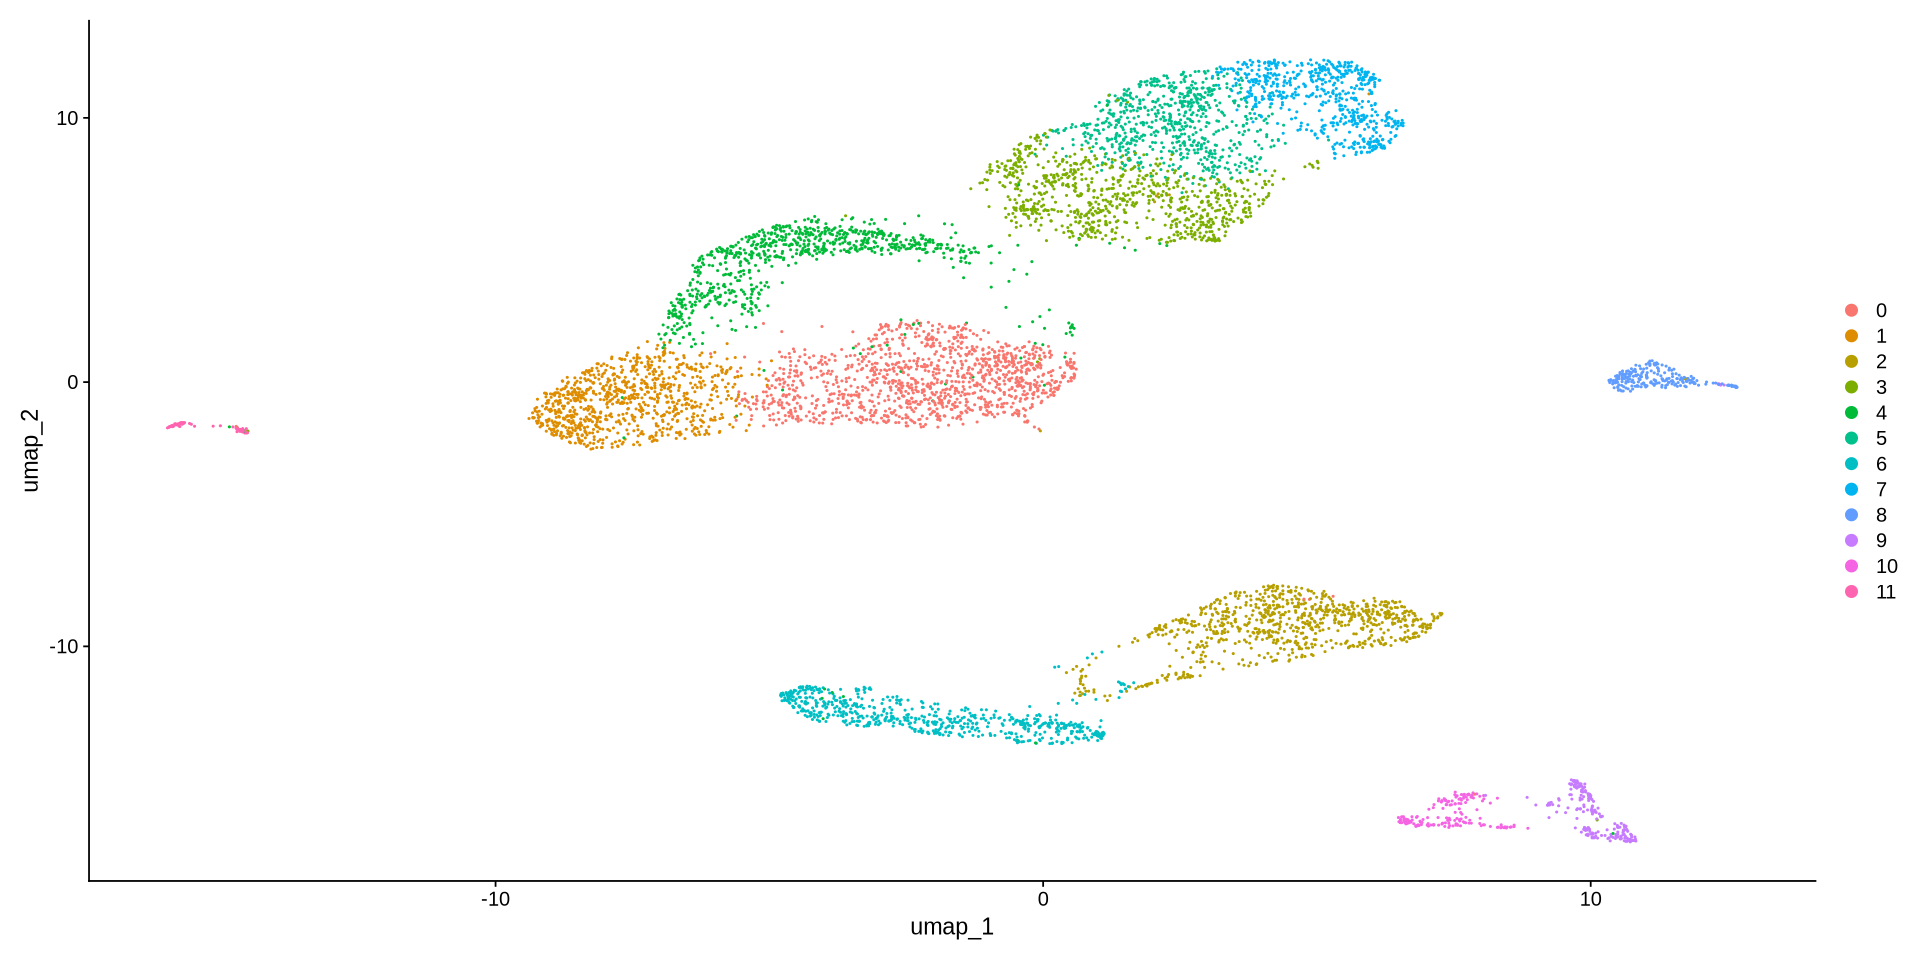

In [70]:
so2 <- RunUMAP(so2, dims = 1:10)
DimPlot(so2, reduction = 'umap')

In [71]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
so2.markers <- FindAllMarkers(so2, only.pos = TRUE)
so2.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    head()

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene  
1 0     4.352489   0.787 0.139 0         0       MUC13 
2 0     2.261611   0.788 0.170 0         0       GC    
3 0     2.563445   0.736 0.143 0         0       IRX2  
4 0     2.992046   0.818 0.350 0         0       PDK4  
5 0     1.687790   0.982 0.539 0         0       GPX3  
6 0     3.384881   0.522 0.094 0         0       VSTM2L

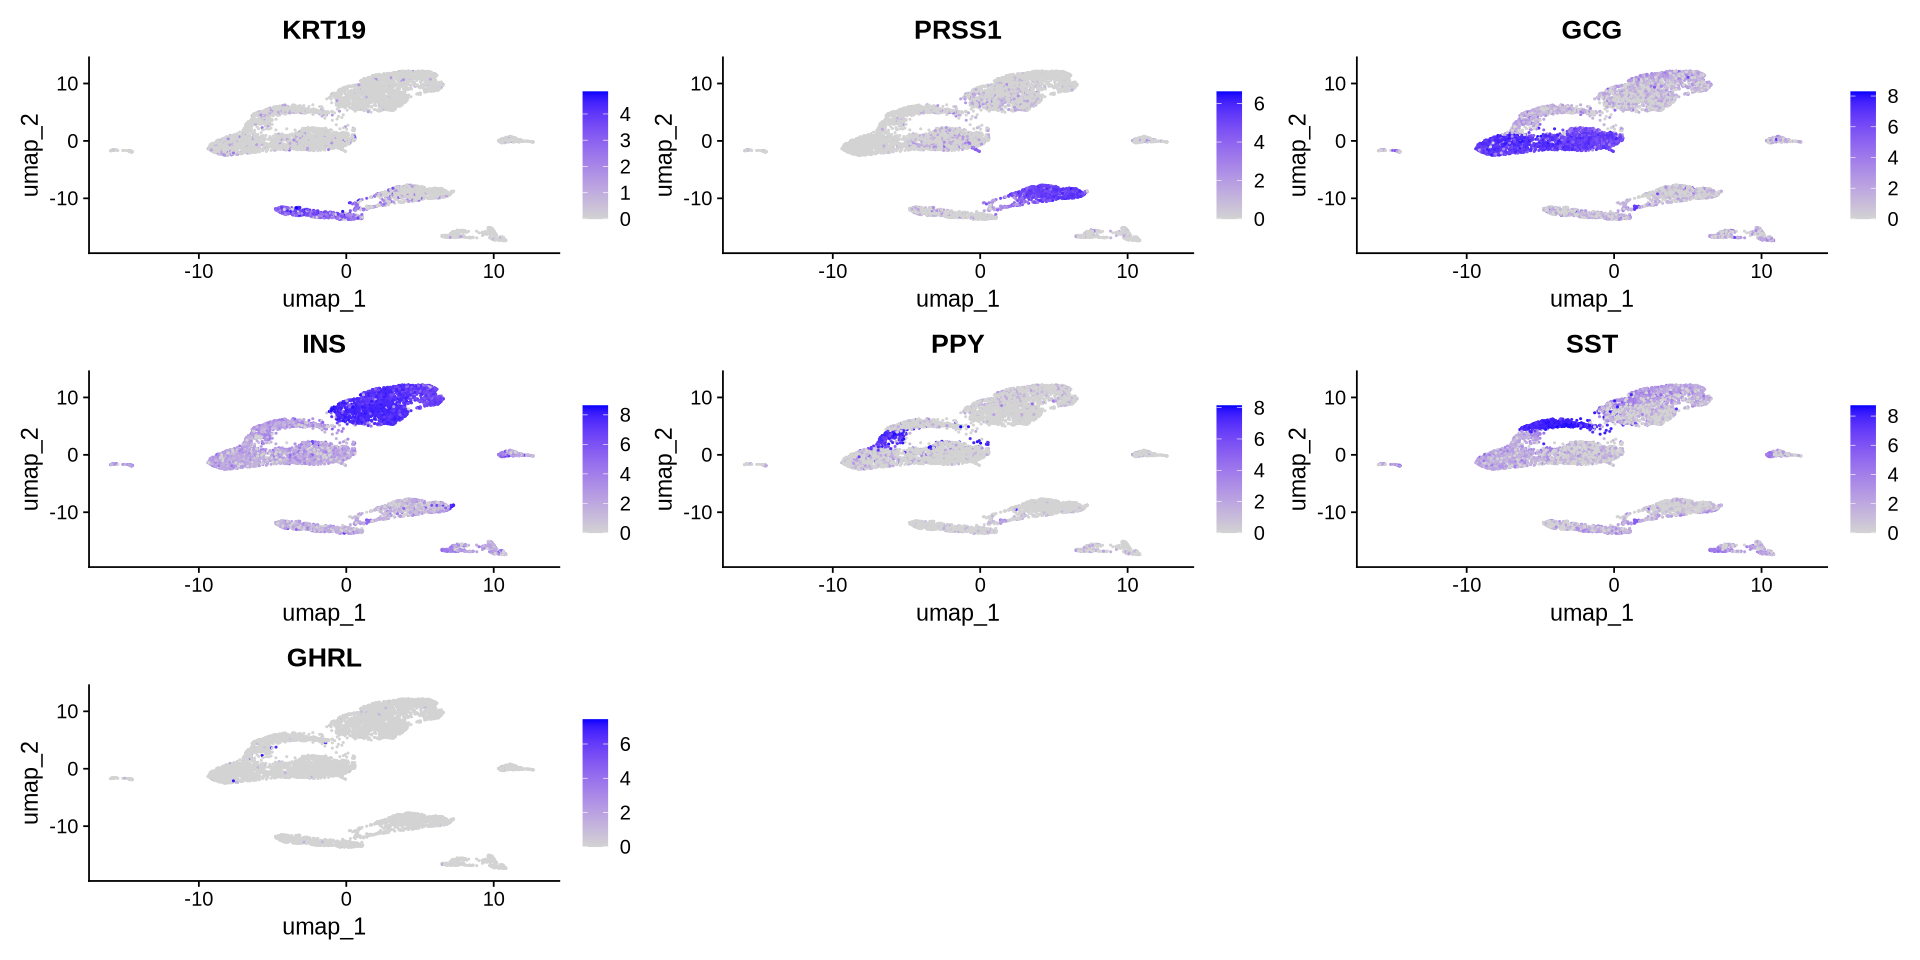

In [72]:
FeaturePlot(so2, features = c("KRT19", "PRSS1", "GCG", "INS", "PPY", "SST", "GHRL"))